
Import Libarys

In [ ]:
!pip install catboost
!pip install torch
!pip install pytorch-tabnet
!pip install sdv # for CTGAN


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.0/197.0 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 109.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.3/198.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.0 MB/s eta 0:00:00


In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report ,f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import kagglehub
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold , train_test_split
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input ,Conv2D, MaxPooling2D,Conv1D, MaxPooling1D, Flatten, Dense, Dropout,LSTM
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.class_weight import compute_sample_weight
import pandas as pd
from sklearn.feature_selection import RFECV
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata

Call The Merged DataSet

In [ ]:
df = pd.read_csv("/content/merged_fire_data_cleaned.csv")
#df = pd.read_csv("merged_fire_data .csv")

print("Class distribution:\n", df["Classes"].value_counts())
print("Combined dataset shape:", df.shape)


Class distribution:
 Classes
0    646
1    210
Name: count, dtype: int64
Combined dataset shape: (856, 14)


In [ ]:
# Features & target
X = df.drop("Classes", axis=1)
y = df["Classes"]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


#Machine Learning

Random Forest

In [ ]:
rf = RandomForestClassifier(random_state=42)
# Define a grid of hyperparameters
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "max_features": ["sqrt", "log2", None]
}

grid_rf = GridSearchCV(rf, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_rf.fit(X_train, y_train)

# Display the best hyperparameter combination found during the search
print("Best params:", grid_rf.best_params_)

# Display the best cross-validation accuracy
print("Best CV Accuracy:", grid_rf.best_score_)

# Explicit Cross-Validation with best model
best_rf = grid_rf.best_estimator_
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring="accuracy")
print("CV Scores:", cv_scores)
print("Mean CV:", cv_scores.mean())

# Test evaluation
y_pred_rf = best_rf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred_rf))
f1_fire = f1_score(y_test, y_pred_rf, average='weighted')
print(f"Overall F1 Score: {f1_fire:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

Best params: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
Best CV Accuracy: 0.9093173035637612
CV Scores: [0.90510949 0.9270073  0.91970803 0.91240876 0.88235294]
Mean CV: 0.9093173035637612
Test Accuracy: 0.9186046511627907
Overall F1 Score: 0.9125

Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95       130
           1       1.00      0.67      0.80        42

    accuracy                           0.92       172
   macro avg       0.95      0.83      0.87       172
weighted avg       0.93      0.92      0.91       172



In [ ]:
# Standardize features:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Logistic Regression


In [ ]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Grid Search
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {"C": [0.01, 0.1, 1, 10], "penalty": ["l2"]}
grid_log = GridSearchCV(log_reg, param_grid, cv=cv, scoring="accuracy")
grid_log.fit(X_train_scaled, y_train)

print("Best params:", grid_log.best_params_)
print("Best CV Accuracy:", grid_log.best_score_)

# Explicit Cross-Validation with best model
best_log = grid_log.best_estimator_
cv_scores = cross_val_score(best_log, X_train_scaled, y_train, cv=5, scoring="accuracy")
print("CV Scores:", cv_scores)
print("Mean CV:", cv_scores.mean())

# Test evaluation
y_pred_log = best_log.predict(X_test_scaled)
print("Test Accuracy:", accuracy_score(y_test, y_pred_log))

f1_fire = f1_score(y_test, y_pred_log, average='weighted')
print(f"Overall F1 Score: {f1_fire:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))


Best params: {'C': 10, 'penalty': 'l2'}
Best CV Accuracy: 0.8932696436238728
CV Scores: [0.88321168 0.89051095 0.90510949 0.90510949 0.88235294]
Mean CV: 0.8932589094031773
Test Accuracy: 0.9069767441860465
Overall F1 Score: 0.9001

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.99      0.94       130
           1       0.96      0.64      0.77        42

    accuracy                           0.91       172
   macro avg       0.93      0.82      0.86       172
weighted avg       0.91      0.91      0.90       172



Support vector machine

In [ ]:
# SVM
svm = SVC(probability=True, random_state=42)

# Grid Search
param_grid = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"],
    "gamma": ["scale", "auto"]
}
grid_svm = GridSearchCV(svm, param_grid, cv=5, scoring="accuracy")
grid_svm.fit(X_train_scaled, y_train)

print("Best params:", grid_svm.best_params_)
print("Best CV Accuracy:", grid_svm.best_score_)

# Explicit Cross-Validation with best model
best_svm = grid_svm.best_estimator_
cv_scores = cross_val_score(best_svm, X_train_scaled, y_train, cv=5, scoring="accuracy")
print("CV Scores:", cv_scores)
print("Mean CV:", cv_scores.mean())

# Test evaluation
y_pred_svm = best_svm.predict(X_test_scaled)
print("Test Accuracy:", accuracy_score(y_test, y_pred_svm))
f1_fire = f1_score(y_test, y_pred_svm, average='weighted')
print(f"Overall F1 Score: {f1_fire:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))

Best params: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best CV Accuracy: 0.8874087591240876
CV Scores: [0.88321168 0.90510949 0.89051095 0.88321168 0.875     ]
Mean CV: 0.8874087591240876
Test Accuracy: 0.8953488372093024
Overall F1 Score: 0.8876

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.98      0.93       130
           1       0.93      0.62      0.74        42

    accuracy                           0.90       172
   macro avg       0.91      0.80      0.84       172
weighted avg       0.90      0.90      0.89       172



In [ ]:
# Encode labels (Convert categorical labels to numbers)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

XGBoost

In [ ]:

xgb = XGBClassifier(
    random_state=42,
    eval_metric="mlogloss"
)

# Grid Search
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}
grid_xgb = GridSearchCV(xgb, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_xgb.fit(X_train, y_train_enc)

print("Best params:", grid_xgb.best_params_)
print("Best CV Accuracy:", grid_xgb.best_score_)

# Explicit Cross-Validation with best model
best_xgb = grid_xgb.best_estimator_
cv_scores = cross_val_score(best_xgb, X_train, y_train_enc, cv=5, scoring="accuracy")
print("CV Scores:", cv_scores)
print("Mean CV:", cv_scores.mean())

# Test evaluation
y_pred_xgb = best_xgb.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test_enc, y_pred_xgb))
f1_fire = f1_score(y_test, y_pred_xgb, average='weighted')
print(f"Overall F1 Score: {f1_fire:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb, target_names=["not fire", "fire"]))

Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
Best CV Accuracy: 0.9385787891799054
CV Scores: [0.94160584 0.95620438 0.9270073  0.94160584 0.92647059]
Mean CV: 0.9385787891799054
Test Accuracy: 0.9651162790697675
Overall F1 Score: 0.9651

Classification Report:
               precision    recall  f1-score   support

    not fire       0.98      0.98      0.98       130
        fire       0.93      0.93      0.93        42

    accuracy                           0.97       172
   macro avg       0.95      0.95      0.95       172
weighted avg       0.97      0.97      0.97       172



CatBoost

In [ ]:
model = CatBoostClassifier(
    verbose=0,
    random_state=42
)

param_grid = {
    'iterations': [200, 400],
    'depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print(" Best Parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_cat = best_model.predict(X_test)

print("\nAccuracy:", round(accuracy_score(y_test, y_pred_cat), 4))
f1_fire = f1_score(y_test, y_pred_cat, average='weighted')
print(f" Overall F1 Score: {f1_fire:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_cat))


Fitting 5 folds for each of 54 candidates, totalling 270 fits
 Best Parameters: {'depth': 4, 'iterations': 400, 'l2_leaf_reg': 5, 'learning_rate': 0.1}

Accuracy: 0.9535
 Overall F1 Score: 0.9531

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       130
           1       0.93      0.88      0.90        42

    accuracy                           0.95       172
   macro avg       0.94      0.93      0.94       172
weighted avg       0.95      0.95      0.95       172



Ensamble Learning

In [ ]:
catboost_model = CatBoostClassifier(
    iterations=400,
    depth=6,
    learning_rate=0.1,
    l2_leaf_reg=3,
    verbose=0,
    random_state=42
)

svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(**grid_svm.best_params_, probability=True, random_state=42))
])

# XGBoost doesn’t need scaling
xgb_model = XGBClassifier(**grid_xgb.best_params_, random_state=42, eval_metric='mlogloss')

# Create the VotingClassifier
voting_clf = VotingClassifier(
    estimators=[
        ('catBoost', catboost_model),
        ('svm', svm_pipeline),
        ('xgb', xgb_model)
    ],
    voting='soft'  # Use soft voting to benefit from predicted probabilities
)

# Fit the ensemble
voting_clf.fit(X_train, y_train_enc)

# Evaluate on test set
y_pred_ensemble = voting_clf.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report
print("Ensemble Test Accuracy:", accuracy_score(y_test_enc, y_pred_ensemble))
f1_fire = f1_score(y_test_enc, y_pred_ensemble, average='weighted')
print(f"Overall F1 Score: {f1_fire:.4f}")

print("\nEnsemble Classification Report:\n", classification_report(y_test, y_pred_ensemble, target_names=["not fire", "fire"]))


Ensemble Test Accuracy: 0.9593023255813954
Overall F1 Score: 0.9591

Ensemble Classification Report:
               precision    recall  f1-score   support

    not fire       0.97      0.98      0.97       130
        fire       0.93      0.90      0.92        42

    accuracy                           0.96       172
   macro avg       0.95      0.94      0.94       172
weighted avg       0.96      0.96      0.96       172



Stacking Classifier


In [ ]:
# Random Forest + GridSearch
rf = RandomForestClassifier(random_state=42)
rf_params = {"n_estimators": [100, 200], "max_depth": [None, 10, 20]}
rf_grid = GridSearchCV(rf, rf_params, cv=cv, scoring="accuracy", n_jobs=-1)
rf_grid.fit(X_train, y_train)
print("Best RF Params:", rf_grid.best_params_)

# XGBoost + GridSearch + Scaling
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_pipe = Pipeline([("scaler", StandardScaler()), ("clf", xgb)])
xgb_params = {"clf__n_estimators": [100, 200], "clf__max_depth": [3, 5, 7], "clf__learning_rate": [0.01, 0.1]}
xgb_grid = GridSearchCV(xgb_pipe, xgb_params, cv=cv, scoring="accuracy", n_jobs=-1)
xgb_grid.fit(X_train, y_train)
print("Best XGB Params:", xgb_grid.best_params_)

# CatBoost + GridSearch
cat = CatBoostClassifier(verbose=0, random_state=42)
cat_params = {"iterations": [200, 500], "depth": [4, 6, 8], "learning_rate": [0.01, 0.1]}
cat_grid = GridSearchCV(cat, cat_params, cv=cv, scoring="accuracy", n_jobs=-1)
cat_grid.fit(X_train, y_train)
print("Best Cat Params:", cat_grid.best_params_)

# Stacking Classifier
estimators = [
    ("rf", rf_grid.best_estimator_),
    ("xgb", xgb_grid.best_estimator_),
    ("cat", cat_grid.best_estimator_)
]
stack_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=cv, n_jobs=-1)

scores = cross_val_score(stack_model, X_train, y_train, cv=cv, scoring="accuracy")
print("Stacking CV Accuracy: %.4f ± %.4f" % (scores.mean(), scores.std()))

stack_model.fit(X_train, y_train)

y_pred_stack = stack_model.predict(X_test)

y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred_stack)

print("Stacking Test Accuracy:", accuracy_score(y_test_labels, y_pred_labels))

f1_fire = f1_score(y_test_labels, y_pred_labels, average='weighted')
print(f"Overall F1 Score: {f1_fire:.4f}")

print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_labels))


Best RF Params: {'max_depth': None, 'n_estimators': 100}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:58:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGB Params: {'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 200}
Best Cat Params: {'depth': 8, 'iterations': 500, 'learning_rate': 0.1}
Stacking CV Accuracy: 0.9474 ± 0.0071
Stacking Test Accuracy: 0.9593023255813954
Overall F1 Score: 0.9591

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       130
           1       0.93      0.90      0.92        42

    accuracy                           0.96       172
   macro avg       0.95      0.94      0.94       172
weighted avg       0.96      0.96      0.96       172



TabNet Model

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.96959 | train_accuracy: 0.51462 | valid_accuracy: 0.50581 |  0:00:00s
epoch 1  | loss: 0.66358 | train_accuracy: 0.59211 | valid_accuracy: 0.62209 |  0:00:00s
epoch 2  | loss: 0.60881 | train_accuracy: 0.66959 | valid_accuracy: 0.6686  |  0:00:00s
epoch 3  | loss: 0.5881  | train_accuracy: 0.72953 | valid_accuracy: 0.68605 |  0:00:00s
epoch 4  | loss: 0.52717 | train_accuracy: 0.72222 | valid_accuracy: 0.7093  |  0:00:00s
epoch 5  | loss: 0.49413 | train_accuracy: 0.72368 | valid_accuracy: 0.68605 |  0:00:01s
epoch 6  | loss: 0.50074 | train_accuracy: 0.74708 | valid_accuracy: 0.72674 |  0:00:01s
epoch 7  | loss: 0.47484 | train_accuracy: 0.77047 | valid_accuracy: 0.75    |  0:00:01s
epoch 8  | loss: 0.43292 | train_accuracy: 0.78801 | valid_accuracy: 0.76163 |  0:00:01s
epoch 9  | loss: 0.40556 | train_accuracy: 0.84064 | valid_accuracy: 0.82558 |  0:00:01s
epoch 10 | loss: 0.41802 | train_accuracy: 0.83626 | valid_accuracy: 0.82558 |  0:00:01s
epoch 11 | loss: 0.38

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


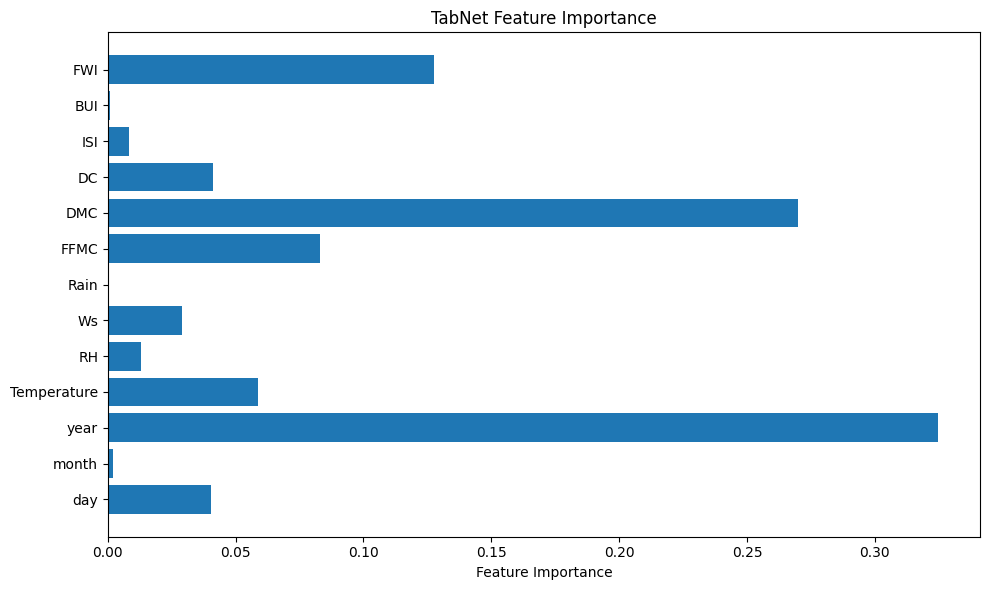

F1 Score: 0.9358


In [ ]:
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_np = X_train_scaled.astype("float32")
X_test_np = X_test_scaled.astype("float32")
y_train_np = y_train.values
y_test_np = y_test.values

# Initialize and Train TabNet
clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=1,
    seed=42
)

clf.fit(
    X_train=X_train_np, y_train=y_train_np,
    eval_set=[(X_train_np, y_train_np), (X_test_np, y_test_np)],
    eval_name=['train', 'valid'],
    eval_metric=['accuracy'],
    max_epochs=70,
    patience=25,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    weights=sample_weights  # fixes the imbalance

)

# Evaluate Model
y_pred = clf.predict(X_test_np)
print("Classification Report:\n", classification_report(y_test_np, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_np, y_pred))

# Plot Feature Importances
feature_names = X.columns
importances = clf.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("TabNet Feature Importance")
plt.tight_layout()
plt.show()
print(f"F1 Score: {f1_score(y_test_np, y_pred, average='weighted'):.4f}")


## Random Oversample

In [ ]:
# Balance the training data by oversampling the minority class
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)
print("Class distribution after RandomOverSampler:", Counter(y_train_res))


Class distribution after RandomOverSampler: Counter({0: 516, 1: 516})


Random Forest

In [ ]:
rf = RandomForestClassifier(random_state=42)

# Define a grid of hyperparameters to search over
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "max_features": ["sqrt", "log2", None]
}

grid_rf = GridSearchCV(rf, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_rf.fit(X_train_res, y_train_res)

# Display the best hyperparameter and accuracy combination found during the search
print("Best params:", grid_rf.best_params_)
print("Best CV Accuracy:", grid_rf.best_score_)

best_rf = grid_rf.best_estimator_
cv_scores = cross_val_score(best_rf, X_train_res, y_train_res, cv=5, scoring="accuracy")
print("CV Scores:", cv_scores)
print("Mean CV:", cv_scores.mean())

y_pred_rf = best_rf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred_rf))

f1_fire = f1_score(y_test, y_pred_rf, average='weighted')
print(f" Overall F1 Score: {f1_fire:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


Best params: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV Accuracy: 0.9506026921814174
CV Scores: [0.92753623 0.95169082 0.94174757 0.96601942 0.96601942]
Mean CV: 0.9506026921814174
Test Accuracy: 0.9534883720930233
 Overall F1 Score: 0.9535

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       130
           1       0.90      0.90      0.90        42

    accuracy                           0.95       172
   macro avg       0.94      0.94      0.94       172
weighted avg       0.95      0.95      0.95       172



Logistic Regression

In [ ]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {"C": [0.01, 0.1, 1, 10], "penalty": ["l2"]}
grid_log = GridSearchCV(log_reg, param_grid, cv=cv, scoring="accuracy")
grid_log.fit(X_train_res_scaled, y_train_res)

print("Best params:", grid_log.best_params_)
print("Best CV Accuracy:", grid_log.best_score_)

best_log = grid_log.best_estimator_
cv_scores = cross_val_score(best_log, X_train_res_scaled, y_train_res, cv=5, scoring="accuracy")

print("CV Scores:", cv_scores)
print("Mean CV:", cv_scores.mean())

y_pred_log = best_log.predict(X_test_scaled)
print("Test Accuracy:", accuracy_score(y_test, y_pred_log))

f1_fire = f1_score(y_test, y_pred_log, average='weighted')
print(f"Overall F1 Score: {f1_fire:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))


Best params: {'C': 0.01, 'penalty': 'l2'}
Best CV Accuracy: 0.8110313775151259
CV Scores: [0.8115942  0.76328502 0.82038835 0.82038835 0.84951456]
Mean CV: 0.8130340978378123
Test Accuracy: 0.8662790697674418
Overall F1 Score: 0.8668

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91       130
           1       0.72      0.74      0.73        42

    accuracy                           0.87       172
   macro avg       0.82      0.82      0.82       172
weighted avg       0.87      0.87      0.87       172



SVM

In [ ]:
svm = SVC(probability=True, random_state=42)

param_grid = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"],
    "gamma": ["scale", "auto"]
}
grid_svm = GridSearchCV(svm, param_grid, cv=5, scoring="accuracy")
grid_svm.fit(X_train_res_scaled, y_train_res)

print("Best params:", grid_svm.best_params_)
print("Best CV Accuracy:", grid_svm.best_score_)

best_svm = grid_svm.best_estimator_
cv_scores = cross_val_score(best_svm, X_train_res_scaled, y_train_res, cv=5, scoring="accuracy")
print("CV Scores:", cv_scores)
print("Mean CV:", cv_scores.mean())

y_pred_svm = best_svm.predict(X_test_scaled)
print("Test Accuracy:", accuracy_score(y_test, y_pred_svm))

f1_fire = f1_score(y_test, y_pred_svm, average='weighted')
print(f"Overall F1 Score: {f1_fire:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))


Best params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV Accuracy: 0.8789034285446273
CV Scores: [0.84541063 0.88405797 0.86407767 0.89805825 0.90291262]
Mean CV: 0.8789034285446273
Test Accuracy: 0.936046511627907
Overall F1 Score: 0.9358

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96       130
           1       0.88      0.86      0.87        42

    accuracy                           0.94       172
   macro avg       0.92      0.91      0.91       172
weighted avg       0.94      0.94      0.94       172



XGBoost  " model selection "

In [ ]:
# XGBoost
xgb = XGBClassifier(random_state=42, eval_metric="mlogloss")

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}
grid_xgb = GridSearchCV(xgb, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_xgb.fit(X_train_res, y_train_res)

print("Best params:", grid_xgb.best_params_)
print("Best CV Accuracy:", grid_xgb.best_score_)

best_xgb1 = grid_xgb.best_estimator_
cv_scores = cross_val_score(best_xgb1, X_train_res, y_train_res, cv=5, scoring="accuracy")
print("CV Scores:", cv_scores)
print("Mean CV:", cv_scores.mean())

y_pred_xgb = best_xgb1.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test_enc, y_pred_xgb))

f1_fire = f1_score(y_test_enc, y_pred_xgb, average='weighted')
print(f"Overall F1 Score: {f1_fire:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))


Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best CV Accuracy: 0.9835232869002392
CV Scores: [0.98550725 0.98550725 0.98058252 0.99029126 0.97572816]
Mean CV: 0.9835232869002392
Test Accuracy: 0.9709302325581395
Overall F1 Score: 0.9708

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       130
           1       0.95      0.93      0.94        42

    accuracy                           0.97       172
   macro avg       0.96      0.96      0.96       172
weighted avg       0.97      0.97      0.97       172



Save the model to use it in our system 'Nuthur'

In [ ]:
joblib.dump(best_xgb1, "best_xgb_model.pkl")
print(" created successfully.")

 created successfully.


CatBoost

In [ ]:
catboost = CatBoostClassifier(
    verbose=0,
    random_state=42
)

param_grid = {
    'iterations': [200, 400],
    'depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5]
}

grid_cat = GridSearchCV(
    estimator=catboost,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_cat.fit(X_train_res, y_train_res)
print("Best Parameters:", grid_cat.best_params_)
print("Best CV Accuracy:", round(grid_cat.best_score_, 4))

best_cat = grid_cat.best_estimator_
cv_scores = cross_val_score(best_cat, X_train_res, y_train_res, cv=5, scoring="accuracy")
print("\nCross-Validation Scores:", cv_scores)
print(" Mean CV Accuracy:", round(cv_scores.mean(), 4))

y_pred = best_cat.predict(X_test)
print("\nTest Accuracy:", round(accuracy_score(y_test, y_pred), 4))

f1_fire = f1_score(y_test, y_pred, average='weighted')
print(f" Overall F1 Score: {f1_fire:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'depth': 8, 'iterations': 400, 'l2_leaf_reg': 1, 'learning_rate': 0.05}
Best CV Accuracy: 0.9874

Cross-Validation Scores: [0.98550725 0.97584541 0.98543689 0.99514563 0.99514563]
 Mean CV Accuracy: 0.9874

Test Accuracy: 0.9593
 Overall F1 Score: 0.9595

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97       130
           1       0.91      0.93      0.92        42

    accuracy                           0.96       172
   macro avg       0.94      0.95      0.95       172
weighted avg       0.96      0.96      0.96       172



Ensamble Learning for the best 3 models

In [ ]:
catboost_model = CatBoostClassifier(
    iterations=400,
    depth=6,
    learning_rate=0.1,
    l2_leaf_reg=3,
    verbose=0,
    random_state=42
)

svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(C=1, kernel='rbf', probability=True, random_state=42))  # استخدم أفضل باراميتراتك
])

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    eval_metric='mlogloss'
)

voting_clf = VotingClassifier(
    estimators=[
        ('catboost', catboost_model),
        ('svm', svm_pipeline),
        ('xgb', xgb_model)
    ],
    voting='soft',
    n_jobs=-1
)

voting_clf.fit(X_train_res, y_train_res)

y_pred_ensemble = voting_clf.predict(X_test)

y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred_ensemble)

print("Ensemble Test Accuracy:", accuracy_score(y_test_labels, y_pred_labels))
f1_fire = f1_score(y_test_labels, y_pred_labels, average='weighted')
print(f"Overall F1 Score: {f1_fire:.4f}")
print("\nEnsemble Classification Report:\n",classification_report(y_test_labels, y_pred_labels))

Ensemble Test Accuracy: 0.9593023255813954
Overall F1 Score: 0.9595

Ensemble Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97       130
           1       0.91      0.93      0.92        42

    accuracy                           0.96       172
   macro avg       0.94      0.95      0.95       172
weighted avg       0.96      0.96      0.96       172



Stacking Classifier


In [ ]:
# Define stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Random Forest model tuning
rf = RandomForestClassifier(random_state=42)
rf_params = {"n_estimators": [100, 200], "max_depth": [None, 10, 20]}
rf_grid = GridSearchCV(rf, rf_params, cv=cv, scoring="accuracy", n_jobs=-1)
rf_grid.fit(X_train_res, y_train_res)
print("Best RF Params:", rf_grid.best_params_)

# XGBoost model tuning with scaling in a pipeline
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_pipe = Pipeline([("scaler", StandardScaler()), ("clf", xgb)])
xgb_params = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [3, 5, 7],
    "clf__learning_rate": [0.01, 0.1]
}
xgb_grid = GridSearchCV(xgb_pipe, xgb_params, cv=cv, scoring="accuracy", n_jobs=-1)
xgb_grid.fit(X_train_res, y_train_res)
print("Best XGB Params:", xgb_grid.best_params_)

# CatBoost model tuning
cat = CatBoostClassifier(verbose=0, random_state=42)
cat_params = {"iterations": [200, 500], "depth": [4, 6, 8], "learning_rate": [0.01, 0.1]}
cat_grid = GridSearchCV(cat, cat_params, cv=cv, scoring="accuracy", n_jobs=-1)
cat_grid.fit(X_train_res, y_train_res)
print("Best Cat Params:", cat_grid.best_params_)

# Build stacking model using the best estimators
estimators = [
    ("rf", rf_grid.best_estimator_),
    ("xgb", xgb_grid.best_estimator_),
    ("cat", cat_grid.best_estimator_)
]
stack_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=cv, n_jobs=-1)

# Cross-validation performance of stacking model
scores = cross_val_score(stack_model, X_train_res, y_train_res, cv=cv, scoring="accuracy")
print("Stacking CV Accuracy: %.4f ± %.4f" % (scores.mean(), scores.std()))

# Train and evaluate on test data
stack_model.fit(X_train_res, y_train_res)
y_pred_stack = stack_model.predict(X_test)

# Decode labels and evaluate performance
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred_stack)

print("Stacking Test Accuracy:", accuracy_score(y_test_labels, y_pred_labels))
f1_fire = f1_score(y_test_labels, y_pred_labels, average='weighted')
print(f"Overall F1 Score: {f1_fire:.4f}")
print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_labels))


Best RF Params: {'max_depth': None, 'n_estimators': 200}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:50:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGB Params: {'clf__learning_rate': 0.1, 'clf__max_depth': 7, 'clf__n_estimators': 200}
Best Cat Params: {'depth': 8, 'iterations': 200, 'learning_rate': 0.1}
Stacking CV Accuracy: 0.9826 ± 0.0095
Stacking Test Accuracy: 0.9651162790697675
Overall F1 Score: 0.9651

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       130
           1       0.93      0.93      0.93        42

    accuracy                           0.97       172
   macro avg       0.95      0.95      0.95       172
weighted avg       0.97      0.97      0.97       172



TabNet model

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.90672 | train_accuracy: 0.63857 | valid_accuracy: 0.72674 |  0:00:00s
epoch 1  | loss: 0.65799 | train_accuracy: 0.76744 | valid_accuracy: 0.72674 |  0:00:00s
epoch 2  | loss: 0.53549 | train_accuracy: 0.74031 | valid_accuracy: 0.78488 |  0:00:00s
epoch 3  | loss: 0.5114  | train_accuracy: 0.75484 | valid_accuracy: 0.77907 |  0:00:01s
epoch 4  | loss: 0.482   | train_accuracy: 0.73159 | valid_accuracy: 0.79651 |  0:00:01s
epoch 5  | loss: 0.48814 | train_accuracy: 0.75194 | valid_accuracy: 0.80233 |  0:00:01s
epoch 6  | loss: 0.47993 | train_accuracy: 0.75194 | valid_accuracy: 0.8314  |  0:00:01s
epoch 7  | loss: 0.42669 | train_accuracy: 0.78004 | valid_accuracy: 0.84302 |  0:00:02s
epoch 8  | loss: 0.4042  | train_accuracy: 0.8062  | valid_accuracy: 0.83721 |  0:00:02s
epoch 9  | loss: 0.39878 | train_accuracy: 0.81492 | valid_accuracy: 0.83721 |  0:00:02s
epoch 10 | loss: 0.38434 | train_accuracy: 0.85174 | valid_accuracy: 0.89535 |  0:00:02s
epoch 11 | loss: 0.36

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


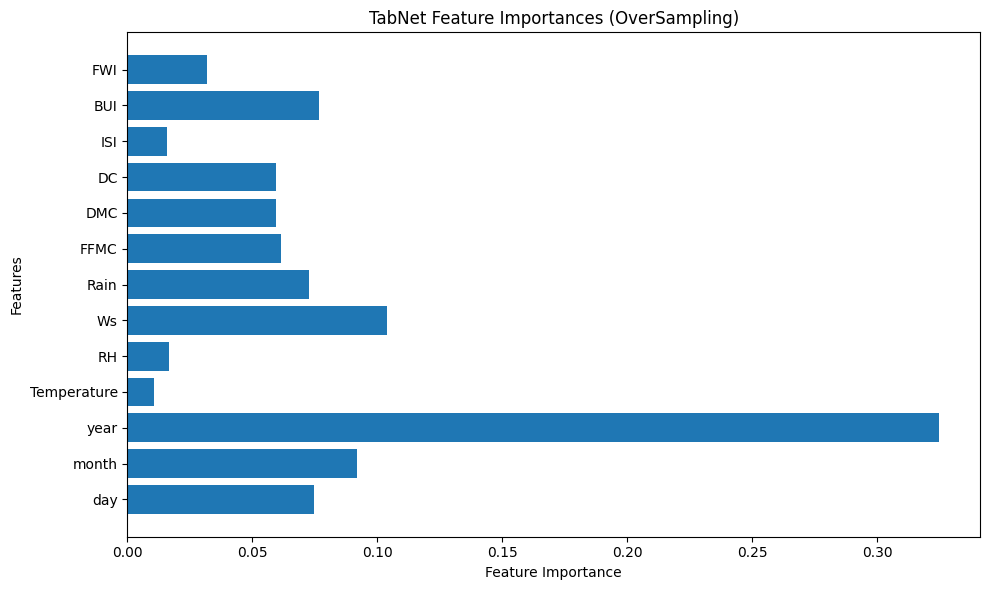

In [ ]:
# FEATURE SCALING
scaler = StandardScaler()
X_train_np = scaler.fit_transform(X_train_res).astype(np.float32)
X_test_np = scaler.transform(X_test).astype(np.float32)
y_train_np = y_train_res.values
y_test_np = y_test.values

# INITIALIZE TABNET
clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    scheduler_params={"step_size":10, "gamma":0.9},
    verbose=1,
    seed=42
)

# TRAIN TABNET
clf.fit(
    X_train=X_train_np, y_train=y_train_np,
    eval_set=[(X_train_np, y_train_np), (X_test_np, y_test_np)],
    eval_name=['train', 'valid'],
    eval_metric=['accuracy'],
    max_epochs=70,
    patience=25,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

# EVALUATION
y_pred = clf.predict(X_test_np)

print(f"F1 Score (OverSampling): {f1_score(y_test_np, y_pred, average='weighted'):.4f}")
print("Classification Report:\n", classification_report(y_test_np, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_np, y_pred))

# FEATURE IMPORTANCE
importances = clf.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(X.columns, importances)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("TabNet Feature Importances (OverSampling)")
plt.tight_layout()
plt.show()

##Random Undersampling

In [ ]:
# undersampling
rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
print("Class distribution after RandomUnderSampler:", Counter(y_train_res))


Class distribution after RandomUnderSampler: Counter({0: 168, 1: 168})


Define Models and Hyperparameter Grids for GridSearchCV

In [ ]:
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

param_grids = {
    "RandomForest": {
        "n_estimators": [100],
        "max_depth": [5, 10],
        "min_samples_split": [2],
        "min_samples_leaf": [1],
        "max_features": ["sqrt"]
    },
    "LogisticRegression": {
        "C": [0.1, 1, 10]
    },
    "SVM": {
        "C": [1, 10],
        "kernel": ["rbf", "linear"]
    },
    "XGBoost": {
        "n_estimators": [100],
        "max_depth": [3, 5]
    }
}


In [ ]:
# Train and evaluate each model using GridSearchCV
for name, model in models.items():
    print(f"\nModel: {name}")

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(model, param_grids[name], cv=cv, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train_res, y_train_res)

    print("Best params:", grid.best_params_)
    print("Best CV Accuracy:", grid.best_score_)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    # Test performance
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print(f"Overall F1 Score: {f1_score(y_test, y_pred, average='weighted'):.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))



Model: RandomForest
Best params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best CV Accuracy: 0.8600087796312555
Test Accuracy: 0.936046511627907
Overall F1 Score: 0.9372

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96       130
           1       0.83      0.93      0.88        42

    accuracy                           0.94       172
   macro avg       0.90      0.93      0.92       172
weighted avg       0.94      0.94      0.94       172


Model: LogisticRegression


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best params: {'C': 10}
Best CV Accuracy: 0.7829675153643547
Test Accuracy: 0.877906976744186
Overall F1 Score: 0.8752

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92       130
           1       0.78      0.69      0.73        42

    accuracy                           0.88       172
   macro avg       0.84      0.81      0.83       172
weighted avg       0.87      0.88      0.88       172


Model: SVM
Best params: {'C': 1, 'kernel': 'linear'}
Best CV Accuracy: 0.7975417032484635
Test Accuracy: 0.9011627906976745
Overall F1 Score: 0.8990

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.95      0.94       130
           1       0.84      0.74      0.78        42

    accuracy                           0.90       172
   macro avg       0.88      0.85      0.86       172
weighted avg       0.90      0.90      0.90       172


Model: XGBoost
Best params:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:58:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


CatBoost

In [ ]:
catboost = CatBoostClassifier(
    verbose=0,
    random_state=42
)

param_grid = {
    'iterations': [200, 400],
    'depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5]
}

grid_cat = GridSearchCV(
    estimator=catboost,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_cat.fit(X_train_res, y_train_res)

print(" Best Parameters:", grid_cat.best_params_)
print(" Best CV Accuracy:", round(grid_cat.best_score_, 4))

best_cat = grid_cat.best_estimator_

cv_scores = cross_val_score(best_cat, X_train_res, y_train_res, cv=5, scoring="accuracy")
print("\nCross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", round(cv_scores.mean(), 4))

y_pred_catb = best_cat.predict(X_test)

print("\nTest Accuracy:", round(accuracy_score(y_test, y_pred_catb), 4))
f1_fire = f1_score(y_test, y_pred_catb, average='weighted')
print(f" Overall F1 Score: {f1_fire:.4f}")
print("\n Classification Report:\n", classification_report(y_test, y_pred_catb))


Fitting 5 folds for each of 54 candidates, totalling 270 fits
 Best Parameters: {'depth': 8, 'iterations': 200, 'l2_leaf_reg': 5, 'learning_rate': 0.1}
 Best CV Accuracy: 0.8899

Cross-Validation Scores: [0.88235294 0.89552239 0.89552239 0.92537313 0.85074627]
Mean CV Accuracy: 0.8899

Test Accuracy: 0.9186
 Overall F1 Score: 0.9209

 Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.92      0.94       130
           1       0.78      0.93      0.85        42

    accuracy                           0.92       172
   macro avg       0.88      0.92      0.90       172
weighted avg       0.93      0.92      0.92       172



Ensamble Learning for the best 3 models

In [ ]:
catboost_model = CatBoostClassifier(
    iterations=400,
    depth=6,
    learning_rate=0.1,
    l2_leaf_reg=3,
    verbose=0,
    random_state=42
)

svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(C=1, kernel='rbf', probability=True, random_state=42))
])

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    eval_metric='mlogloss'
)

voting_clf = VotingClassifier(
    estimators=[
        ('catboost', catboost_model),
        ('svm', svm_pipeline),
        ('xgb', xgb_model)
    ],
    voting='soft',  # soft voting
    n_jobs=-1
)

voting_clf.fit(X_train_res, y_train_res)

y_pred_ensemble = voting_clf.predict(X_test)

y_test_labels = le.inverse_transform(y_test_enc)
y_pred_labels = le.inverse_transform(y_pred_ensemble)

print("Ensemble Test Accuracy:", accuracy_score(y_test_labels, y_pred_labels))
f1_fire = f1_score(y_test_labels, y_pred_labels, average='weighted')
print(f"Overall F1 Score: {f1_fire:.4f}")
print("\nEnsemble Classification Report:\n",
      classification_report(y_test_labels, y_pred_labels))


Ensemble Test Accuracy: 0.936046511627907
Overall F1 Score: 0.9372

Ensemble Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96       130
           1       0.83      0.93      0.88        42

    accuracy                           0.94       172
   macro avg       0.90      0.93      0.92       172
weighted avg       0.94      0.94      0.94       172



Staking Ensamble

In [ ]:
# 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf = RandomForestClassifier(random_state=42)
rf_params = {"n_estimators": [100, 200], "max_depth": [None, 10, 20]}
rf_grid = GridSearchCV(rf, rf_params, cv=cv, scoring="accuracy", n_jobs=-1)
rf_grid.fit(X_train_res, y_train_res)
print("Best RF Params:", rf_grid.best_params_)

xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_pipe = Pipeline([("scaler", StandardScaler()), ("clf", xgb)])
xgb_params = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [3, 5, 7],
    "clf__learning_rate": [0.01, 0.1]
}
xgb_grid = GridSearchCV(xgb_pipe, xgb_params, cv=cv, scoring="accuracy", n_jobs=-1)
xgb_grid.fit(X_train_res, y_train_res)
print("Best XGB Params:", xgb_grid.best_params_)


cat = CatBoostClassifier(verbose=0, random_state=42)
cat_params = {"iterations": [200, 500], "depth": [4, 6, 8], "learning_rate": [0.01, 0.1]}
cat_grid = GridSearchCV(cat, cat_params, cv=cv, scoring="accuracy", n_jobs=-1)
cat_grid.fit(X_train_res, y_train_res)
print("Best Cat Params:", cat_grid.best_params_)

# Build stacking model using best estimators
estimators = [
    ("rf", rf_grid.best_estimator_),
    ("xgb", xgb_grid.best_estimator_),
    ("cat", cat_grid.best_estimator_)
]
# Create a stacking ensemble with Logistic Regression as the meta-model
stack_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=cv, n_jobs=-1)

# Cross-validation results
scores = cross_val_score(stack_model, X_train_res, y_train_res, cv=cv, scoring="accuracy")
print("Stacking CV Accuracy: %.4f ± %.4f" % (scores.mean(), scores.std()))

# Train and test performance
stack_model.fit(X_train_res, y_train_res)
y_pred_stack = stack_model.predict(X_test)

# Decode and evaluate
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred_stack)
print("Stacking Test Accuracy:", accuracy_score(y_test_labels, y_pred_labels))
f1_fire = f1_score(y_test_labels, y_pred_labels, average='weighted')
print(f"Overall F1 Score: {f1_fire:.4f}")
print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_labels))


Best RF Params: {'max_depth': None, 'n_estimators': 100}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:17:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGB Params: {'clf__learning_rate': 0.01, 'clf__max_depth': 7, 'clf__n_estimators': 100}
Best Cat Params: {'depth': 8, 'iterations': 500, 'learning_rate': 0.1}
Stacking CV Accuracy: 0.8781 ± 0.0454
Stacking Test Accuracy: 0.9244186046511628
Overall F1 Score: 0.9267

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.92      0.95       130
           1       0.78      0.95      0.86        42

    accuracy                           0.92       172
   macro avg       0.88      0.93      0.90       172
weighted avg       0.93      0.92      0.93       172



#Deep Learning

TabNet Model

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.13282 | train_accuracy: 0.44048 | valid_accuracy: 0.39535 |  0:00:00s
epoch 1  | loss: 0.78413 | train_accuracy: 0.48512 | valid_accuracy: 0.48256 |  0:00:00s
epoch 2  | loss: 0.72751 | train_accuracy: 0.47321 | valid_accuracy: 0.51163 |  0:00:00s
epoch 3  | loss: 0.65746 | train_accuracy: 0.5625  | valid_accuracy: 0.54651 |  0:00:00s
epoch 4  | loss: 0.61029 | train_accuracy: 0.62798 | valid_accuracy: 0.61628 |  0:00:00s
epoch 5  | loss: 0.60416 | train_accuracy: 0.68155 | valid_accuracy: 0.67442 |  0:00:00s
epoch 6  | loss: 0.5623  | train_accuracy: 0.70536 | valid_accuracy: 0.73837 |  0:00:01s
epoch 7  | loss: 0.55766 | train_accuracy: 0.72917 | valid_accuracy: 0.73256 |  0:00:01s
epoch 8  | loss: 0.53366 | train_accuracy: 0.72024 | valid_accuracy: 0.69767 |  0:00:01s
epoch 9  | loss: 0.51804 | train_accuracy: 0.70238 | valid_accuracy: 0.70349 |  0:00:01s
epoch 10 | loss: 0.54051 | train_accuracy: 0.6994  | valid_accuracy: 0.72093 |  0:00:01s
epoch 11 | loss: 0.50

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


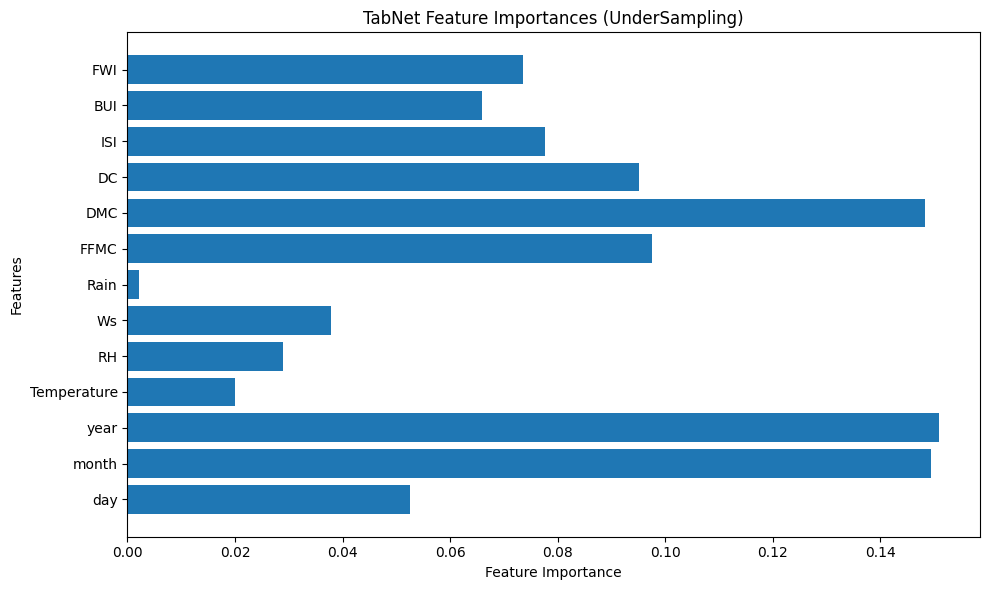

In [ ]:
#  FEATURE SCALING
scaler = StandardScaler()
X_train_np = scaler.fit_transform(X_train_res).astype(np.float32)
X_test_np = scaler.transform(X_test).astype(np.float32)
y_train_np = y_train_res.values
y_test_np = y_test.values

# INITIALIZE TABNET
clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    scheduler_params={"step_size":10, "gamma":0.9},
    verbose=1,
    seed=42
)

# TRAIN TABNET
clf.fit(
    X_train=X_train_np, y_train=y_train_np,
    eval_set=[(X_train_np, y_train_np), (X_test_np, y_test_np)],
    eval_name=['train', 'valid'],
    eval_metric=['accuracy'],
    max_epochs=70,
    patience=25,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

# EVALUATION
y_pred = clf.predict(X_test_np)

print(f"F1 Score (UnderSampling): {f1_score(y_test_np, y_pred, average='weighted'):.4f}")
print("Classification Report:\n", classification_report(y_test_np, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_np, y_pred))

# FEATURE IMPORTANCE
importances = clf.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(X.columns, importances)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("TabNet Feature Importances (UnderSampling)")
plt.tight_layout()
plt.show()

LSTM

In [ ]:
# Reshape (3D: samples, timesteps, features)
X_train_lstm = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

model_lstm = Sequential([
    LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]),
         kernel_regularizer=regularizers.l2(0.001), return_sequences=False),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model_lstm.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history_lstm = model_lstm.fit(
    X_train_lstm, y_train_enc,
    validation_data=(X_test_lstm, y_test_enc),
    epochs=70, batch_size=16, verbose=1,
    callbacks=[early_stop]
)

loss, acc = model_lstm.evaluate(X_test_lstm, y_test_enc, verbose=0)
print("LSTM Test Accuracy:", acc)

y_pred_probs = model_lstm.predict(X_test_lstm)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()
y_true_classes = y_test_enc

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(f"\nConfusion Matrix:\n {cm}")

# Classification Report
print(f"\nClassification Report:{classification_report(y_true_classes, y_pred_classes)}")

# F1 Score
f1_fire = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f"\nF1 Score: {f1_fire:.4f}")


Epoch 1/70


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.7099 - loss: 0.5992 - val_accuracy: 0.7558 - val_loss: 0.4948
Epoch 2/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7729 - loss: 0.5022 - val_accuracy: 0.8372 - val_loss: 0.4551
Epoch 3/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8077 - loss: 0.4549 - val_accuracy: 0.8663 - val_loss: 0.4257
Epoch 4/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8424 - loss: 0.4338 - val_accuracy: 0.8721 - val_loss: 0.4048
Epoch 5/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8572 - loss: 0.4038 - val_accuracy: 0.8721 - val_loss: 0.3787
Epoch 6/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8392 - loss: 0.4497 - val_accuracy: 0.8895 - val_loss: 0.3612
Epoch 7/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8576 - loss: 0.3929 - val_accuracy: 0.8895 - val_loss: 0.3543
Epoch 8/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8626 - loss: 0.3854 - val_accuracy: 0.8663 - val_loss: 0.

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

Confusion Matrix:
 [[127   3]
 [ 15  27]]

Classification Report:              precision    recall  f1-score   support

           0       0.89      0.98      0.93       130
           1       0.90      0.64      0.75        42

    accuracy                           0.90       172
   macro avg       0.90      0.81      0.84       172
weighted avg       0.90      0.90      0.89       172


F1 Score: 0.8889


CNN1D

In [ ]:
X_train_cnn = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

model_cnn = Sequential([
    Conv1D(filters=64, kernel_size=3, activation="relu",
           kernel_regularizer=regularizers.l2(0.001),
           input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Flatten(),
    Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model_cnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history_cnn = model_cnn.fit(
    X_train_cnn, y_train_enc,
    validation_data=(X_test_cnn, y_test_enc),
    epochs=50, batch_size=16, verbose=1,
    callbacks=[early_stop]
)

loss, acc = model_cnn.evaluate(X_test_cnn, y_test_enc, verbose=0)
print("CNN1D Test Accuracy:", acc)

y_pred_probs = model_cnn.predict(X_test_cnn)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()
y_true_classes = y_test_enc


# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(f"\nConfusion Matrix:\n{cm}")

# Classification Report
print(f"\nClassification Report:\n{classification_report(y_true_classes, y_pred_classes)}")

# F1 Score
f1_fire = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f"\nF1 Score: {f1_fire:.4f}")


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5495 - loss: 130.9913 - val_accuracy: 0.7558 - val_loss: 8.5601
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6163 - loss: 51.4302 - val_accuracy: 0.7558 - val_loss: 10.2711
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6230 - loss: 25.2604 - val_accuracy: 0.7558 - val_loss: 1.6108
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6192 - loss: 15.1715 - val_accuracy: 0.8256 - val_loss: 0.5967
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5901 - loss: 10.9311 - val_accuracy: 0.7558 - val_loss: 0.6098
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6159 - loss: 8.1180 - val_accuracy: 0.7558 - val_loss: 0.6206
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6503 - loss: 3.1443 - val_accuracy: 0.7558 - val_loss: 0.6831
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6828 - loss: 2.6130 - val_accuracy: 0.7558 - val_los

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Confusion Matrix:
[[113  17]
 [ 13  29]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       130
           1       0.63      0.69      0.66        42

    accuracy                           0.83       172
   macro avg       0.76      0.78      0.77       172
weighted avg       0.83      0.83      0.83       172


F1 Score: 0.8282


MLP

In [ ]:
X_train_mlp = X_train.values
X_test_mlp = X_test.values

model_mlp = Sequential([
    Dense(128, activation="relu", input_shape=(X_train_mlp.shape[1],),
          kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.6),
    Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.6),
    Dense(1, activation="sigmoid")
])
model_mlp.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history_mlp = model_mlp.fit(
    X_train_mlp, y_train_enc,
    validation_data=(X_test_mlp, y_test_enc),
    epochs=20, batch_size=16, verbose=1,
    callbacks=[early_stop]
)
loss, acc = model_mlp.evaluate(X_test_mlp, y_test_enc, verbose=0)
print("MLP Test Accuracy:", acc)

y_pred_probs = model_mlp.predict(X_test_mlp)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()
y_true_classes = y_test_enc

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(f"\nConfusion Matrix:\n{cm}")

# Classification Report
print(f"\nClassification Report:\n{classification_report(y_true_classes, y_pred_classes)}")

# F1 Score
f1_fire = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f"\nF1 Score: {f1_fire:.4f}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6035 - loss: 152.3399 - val_accuracy: 0.7558 - val_loss: 28.6138
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6330 - loss: 91.9284 - val_accuracy: 0.7558 - val_loss: 12.9988
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6529 - loss: 83.9114 - val_accuracy: 0.7558 - val_loss: 2.7905
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6594 - loss: 43.3250 - val_accuracy: 0.3430 - val_loss: 2.3818
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6589 - loss: 36.4663 - val_accuracy: 0.3198 - val_loss: 6.7732
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5790 - loss: 23.8043 - val_accuracy: 0.5233 - val_loss: 0.6909
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6241 - loss: 14.3223 - val_accuracy: 0.5000 - val_loss: 0.7086
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6354 - loss: 11.3510 - val_accuracy: 0.7558

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


CNN2D

In [ ]:
#CNN2D: (samples, rows, cols, channels)
X_train_cnn2d = X_train_scaled.reshape(-1, X_train_scaled.shape[1], 1, 1)
X_test_cnn2d = X_test_scaled.reshape(-1, X_test_scaled.shape[1], 1, 1)

#buikd the model
model_cnn2d = Sequential([
    Conv2D(filters=32, kernel_size=(3,1), activation='relu',
           kernel_regularizer=regularizers.l2(0.001),
           input_shape=(X_train_cnn2d.shape[1], X_train_cnn2d.shape[2], 1)),
    MaxPooling2D(pool_size=(2,1)),
    Dropout(0.5),

    Conv2D(filters=64, kernel_size=(3,1), activation='relu',
           kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D(pool_size=(2,1)),
    Dropout(0.5),

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile
model_cnn2d.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training
history_cnn2d = model_cnn2d.fit(
    X_train_cnn2d, y_train_enc,
    validation_data=(X_test_cnn2d, y_test_enc),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# Evaluation
loss, acc = model_cnn2d.evaluate(X_test_cnn2d, y_test_enc, verbose=0)
print(" CNN2D Test Accuracy:", acc)

y_pred_probs = model_cnn2d.predict(X_test_cnn2d)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()
y_true_classes = y_test_enc

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(f"\nConfusion Matrix:\n{cm}")

# Classification Report
print(f"\nClassification Report:\n{classification_report(y_true_classes, y_pred_classes)}")

# F1 Score
f1_fire = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f"\n F1 Score: {f1_fire:.4f}")

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7036 - loss: 0.7315 - val_accuracy: 0.7558 - val_loss: 0.6019
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7502 - loss: 0.6525 - val_accuracy: 0.7558 - val_loss: 0.5569
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7662 - loss: 0.5882 - val_accuracy: 0.7965 - val_loss: 0.5190
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7996 - loss: 0.5420 - val_accuracy: 0.8488 - val_loss: 0.4865
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8238 - loss: 0.5162 - val_accuracy: 0.8605 - val_loss: 0.4542
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8399 - loss: 0.4835 - val_accuracy: 0.8721 - val_loss: 0.4388
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8575 - loss: 0.4929 - val_accuracy: 0.8663 - val_loss: 0.4345
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8442 - loss: 0.4966 - val_accuracy: 0.8663 - val_loss: 0.424

##Random Oversampler

In [ ]:
ros = RandomOverSampler(random_state=42)
X_over, y_over = ros.fit_resample(X_train_scaled, y_train)

print("Befor OverSampling:", y_train.value_counts().to_dict())
print("After OverSampling:", y_over.value_counts().to_dict())



Befor OverSampling: {0: 516, 1: 168}
After OverSampling: {0: 516, 1: 516}


In [ ]:
# Convert integer labels (0/1) into one-hot encoded vectors for training
y_over_cat = to_categorical(y_over, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

LSTM

In [ ]:
X_over_lstm = X_over.reshape((X_over.shape[0], X_over.shape[1], 1))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))


model_lstm = Sequential([
    Input(shape=(X_over_lstm.shape[1], X_over_lstm.shape[2])),
    LSTM(64, kernel_regularizer=regularizers.l2(0.001), return_sequences=False),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model_lstm.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)


history_lstm = model_lstm.fit(
    X_over_lstm, y_over,
    validation_data=(X_test_lstm, y_test),
    epochs=50,
    batch_size=16,
    verbose=1,
    callbacks=[early_stop]
)


loss, acc = model_lstm.evaluate(X_test_lstm, y_test, verbose=0)
print("LSTM (After RandomOverSampling) Test Accuracy:", acc)

y_pred_probs = model_lstm.predict(X_test_lstm)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()
y_true_classes = y_test_enc

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(f"\nConfusion Matrix:\n{cm}")

# Classification Report
print(f"\n Classification Report:{classification_report(y_true_classes, y_pred_classes)}")

# F1 Score
f1_fire = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f"\nF1 Score: {f1_fire:.4f}")


Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.6139 - loss: 0.6642 - val_accuracy: 0.7326 - val_loss: 0.5191
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7262 - loss: 0.5161 - val_accuracy: 0.8314 - val_loss: 0.4685
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7869 - loss: 0.4685 - val_accuracy: 0.8256 - val_loss: 0.4812
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7484 - loss: 0.5079 - val_accuracy: 0.8605 - val_loss: 0.4315
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7819 - loss: 0.4502 - val_accuracy: 0.8605 - val_loss: 0.4211
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7603 - loss: 0.4688 - val_accuracy: 0.8488 - val_loss: 0.4528
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7844 - loss: 0.4350 - val_accuracy: 0.8430 - val_loss: 0.4325
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7745 - loss: 0.4539 - val_accuracy: 0.8430 - val_loss

CNN1D

In [ ]:
X_over_cnn = X_over.reshape((X_over.shape[0], X_over.shape[1], 1))
X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

model_cnn = Sequential([
    Conv1D(filters=64, kernel_size=3, activation="relu",
           kernel_regularizer=regularizers.l2(0.001),
           input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Flatten(),
    Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model_cnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history_cnn = model_cnn.fit(
    X_over_cnn, y_over,
    validation_data=(X_test_cnn, y_test),
    epochs=50, batch_size=16, verbose=1,
    callbacks=[early_stop]
)


loss, acc = model_cnn.evaluate(X_test_cnn, y_test, verbose=0)
print("CNN1D Test Accuracy:", acc)

y_pred_probs = model_cnn.predict(X_test_cnn)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()
y_true_classes = y_test

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(f"\nConfusion Matrix:\n{cm}")

# Classification Report
print(f"\n Classification Report:{classification_report(y_true_classes, y_pred_classes)}")

# F1 Score
f1_fire = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f"\n F1 Score: {f1_fire:.4f}")


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6542 - loss: 0.7181 - val_accuracy: 0.7907 - val_loss: 0.6135
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7798 - loss: 0.5593 - val_accuracy: 0.8256 - val_loss: 0.5213
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7856 - loss: 0.5480 - val_accuracy: 0.8721 - val_loss: 0.4623
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7959 - loss: 0.5315 - val_accuracy: 0.8779 - val_loss: 0.4557
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8057 - loss: 0.4899 - val_accuracy: 0.8605 - val_loss: 0.4699
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8009 - loss: 0.4963 - val_accuracy: 0.8547 - val_loss: 0.4639
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8055 - loss: 0.4771 - val_accuracy: 0.8837 - val_loss: 0.4248
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8038 - loss: 0.4831 - val_accuracy: 0.8663 - val_loss: 0.4362
Ep

MLP

In [ ]:
# Prepare data for MLP model
X_over_mlp = X_over
X_test_mlp = X_test_scaled

# Build the MLP model
model_mlp = Sequential([
    Input(shape=(X_train_mlp.shape[1],)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.0005)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.0005)),
    Dropout(0.2),
    Dense(1, activation='sigmoid') # Output layer for binary classification
])

# Compile the model (binary crossentropy + Adam optimizer)
model_mlp.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train the model
history_mlp = model_mlp.fit(
    X_over_mlp, y_over,
    validation_data=(X_test_mlp, y_test),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate model performance
loss, acc = model_mlp.evaluate(X_test_mlp, y_test, verbose=0)
print("MLP Test Accuracy:", acc)

# Predict class probabilities and convert to class labels
y_pred_probs = model_mlp.predict(X_test_mlp)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()
y_true_classes = y_test

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(f"\nConfusion Matrix:\n{cm}")

# Classification Report
print(f"\nClassification Report:\n{classification_report(y_true_classes, y_pred_classes)}")

# F1 Score
f1_fire = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f"\nF1 Score: {f1_fire:.4f}")


Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5134 - loss: 0.7203 - val_accuracy: 0.8663 - val_loss: 0.5191
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7623 - loss: 0.5147 - val_accuracy: 0.8721 - val_loss: 0.4384
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8013 - loss: 0.4566 - val_accuracy: 0.8895 - val_loss: 0.4226
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7939 - loss: 0.4393 - val_accuracy: 0.8895 - val_loss: 0.4099
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8164 - loss: 0.4129 - val_accuracy: 0.8895 - val_loss: 0.3974
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7970 - loss: 0.4323 - val_accuracy: 0.9012 - val_loss: 0.3774
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8027 - loss: 0.4201 - val_accuracy: 0.9012 - val_loss: 0.3607
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8422 - loss: 0.3799 - val_accuracy: 0.8953 - val_loss:

CNN2D

In [ ]:
X_over_cnn2d = X_over.reshape(-1, X_over.shape[1], 1, 1)
X_test_cnn2d = X_test_scaled.reshape(-1, X_test_scaled.shape[1], 1, 1)

model_cnn2d = Sequential([
    Conv2D(filters=32, kernel_size=(3,1), activation='relu',
           kernel_regularizer=regularizers.l2(0.001),
           input_shape=(X_train_cnn2d.shape[1], X_train_cnn2d.shape[2], 1)),
    MaxPooling2D(pool_size=(2,1)),
    Dropout(0.5),

    Conv2D(filters=64, kernel_size=(3,1), activation='relu',
           kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D(pool_size=(2,1)),
    Dropout(0.5),

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # one-hot labels
])

# Compile
model_cnn2d.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training
history_cnn2d = model_cnn2d.fit(
    X_over_cnn2d, y_over,
    validation_data=(X_test_cnn2d, y_test),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)
# Evaluation
loss, acc = model_cnn2d.evaluate(X_test_cnn2d, y_test, verbose=0)
print("CNN2D Test Accuracy:", acc)

y_pred_probs = model_cnn2d.predict(X_test_cnn2d)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()
y_true_classes = y_test

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(f"\nConfusion Matrix:\n{cm}")

# Classification Report
print(f"\nClassification Report:\n{classification_report(y_true_classes, y_pred_classes)}")

# F1 Score
f1_fire = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f"\nF1 Score: {f1_fire:.4f}")

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5196 - loss: 0.8063 - val_accuracy: 0.8547 - val_loss: 0.6904
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6356 - loss: 0.7217 - val_accuracy: 0.8140 - val_loss: 0.6194
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7442 - loss: 0.6297 - val_accuracy: 0.8372 - val_loss: 0.5494
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7325 - loss: 0.6193 - val_accuracy: 0.8081 - val_loss: 0.5880
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7871 - loss: 0.5803 - val_accuracy: 0.8605 - val_loss: 0.5093
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7756 - loss: 0.5646 - val_accuracy: 0.8605 - val_loss: 0.5169
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7847 - loss: 0.5683 - val_accuracy: 0.8663 - val_loss: 0.4953
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8071 - loss: 0.5321 - val_accuracy: 0.8605 - val_loss: 0.5155
Epo

##Random Undersampler

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(X_train_scaled, y_train)

print("Befor UnderSampling:", y_train.value_counts().to_dict())
print("After UnderSampling:",  y_under.value_counts().to_dict())


Befor UnderSampling: {0: 516, 1: 168}
After UnderSampling: {0: 168, 1: 168}


Random Undersampler for MLP, LSTM, CNN1D,  CNN2D

In [ ]:
# MLP
X_mlp = X_under
X_test_mlp = X_test_scaled

model_mlp = Sequential([
    Input(shape=(X_train_mlp.shape[1],)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.0005)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.0005)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# compile
model_mlp.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# EarlyStopping
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history_mlp = model_mlp.fit(
    X_mlp, y_under,
    validation_data=(X_test_mlp, y_test),
    epochs=100, batch_size=16, callbacks=[early_stop], verbose=1
)
loss, acc = model_mlp.evaluate(X_test_mlp, y_test, verbose=0)
print("MLP Test Accuracy after UnderSampling:", acc)

y_pred_probs = model_mlp.predict(X_test_mlp)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()
y_true_classes = y_test

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(f"\nConfusion Matrix:\n{cm}")

# Classification Report
print(f"\nClassification Report:\n{classification_report(y_true_classes, y_pred_classes)}")

# F1 Score
f1_fire = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f"\nF1 Score: {f1_fire:.4f}")

#_______________________________________________________________________________________
# CNN1D
X_cnn1d = X_under.reshape(-1, X_under.shape[1], 1)
X_test_cnn1d = X_test_scaled.reshape(-1, X_test_scaled.shape[1], 1)

model_cnn = Sequential([
    Conv1D(filters=64, kernel_size=3, activation="relu",
           kernel_regularizer=regularizers.l2(0.001),
           input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Flatten(),
    Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model_cnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history_cnn= model_cnn.fit(
    X_cnn1d, y_under,
    validation_data=(X_test_cnn1d, y_test),
    epochs=50, batch_size=16, callbacks=[early_stop], verbose=1
)
loss, acc = model_cnn.evaluate(X_test_cnn1d, y_test, verbose=0)
print("CNN1D Test Accuracy after UnderSampling:", acc)

y_pred_probs = model_cnn.predict(X_test_cnn1d)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()
y_true_classes = y_test

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(f"\nConfusion Matrix:\n{cm}")

# Classification Report
print(f"\nClassification Report:\n{classification_report(y_true_classes, y_pred_classes)}")

# F1 Score
f1_fire = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f"\nF1 Score: {f1_fire:.4f}")

#_______________________________________________________________________________________
# CNN2D
X_cnn2d = X_under.reshape(-1, X_under.shape[1], 1, 1)
X_test_cnn2d = X_test_scaled.reshape(-1, X_test_scaled.shape[1], 1, 1)

model_cnn2d = Sequential([
    Conv2D(filters=32, kernel_size=(3,1), activation='relu',
           kernel_regularizer=regularizers.l2(0.001),
           input_shape=(X_train_cnn2d.shape[1], X_train_cnn2d.shape[2], 1)),
    MaxPooling2D(pool_size=(2,1)),
    Dropout(0.5),

    Conv2D(filters=64, kernel_size=(3,1), activation='relu',
           kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D(pool_size=(2,1)),
    Dropout(0.5),

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # one-hot labels
])

# Compile
model_cnn2d.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_cnn2d = model_cnn2d.fit(
    X_cnn2d, y_under,
    validation_data=(X_test_cnn2d, y_test),
    epochs=50, batch_size=16, callbacks=[early_stop], verbose=1
)
loss, acc = model_cnn2d.evaluate(X_test_cnn2d, y_test, verbose=0)
print("CNN2D Test Accuracy after UnderSampling:", acc)

y_pred_probs = model_cnn2d.predict(X_test_cnn2d)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()
y_true_classes = y_test

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(f"\nConfusion Matrix:\n{cm}")

# Classification Report
print(f"\nClassification Report\n{classification_report(y_true_classes, y_pred_classes)}")

# F1 Score
f1_fire = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f"\nF1 Score: {f1_fire:.4f}")

#_______________________________________________________________________________________
# LSTM
X_lstm = X_under.reshape(-1, X_under.shape[1], 1)
X_test_lstm = X_test_scaled.reshape(-1, X_test_scaled.shape[1], 1)

model_lstm = Sequential([
    Input(shape=(X_over_lstm.shape[1], X_over_lstm.shape[2])),
    LSTM(64, kernel_regularizer=regularizers.l2(0.001), return_sequences=False),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model_lstm.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history_lstm = model_lstm.fit(
    X_lstm, y_under,
    validation_data=(X_test_lstm, y_test),
    epochs=50, batch_size=16, callbacks=[early_stop], verbose=1
)
loss, acc = model_lstm.evaluate(X_test_lstm, y_test, verbose=0)
print("LSTM Test Accuracy after UnderSampling:", acc)

y_pred_probs = model_lstm.predict(X_test_lstm)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()
y_true_classes = y_test


# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(f"\nConfusion Matrix:\n{cm}")

# Classification Report
print(f"\nClassification Report:\n{classification_report(y_true_classes, y_pred_classes)}")

# F1 Score
f1_fire = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f"\nF1 Score: {f1_fire:.4f}")

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4404 - loss: 0.7825 - val_accuracy: 0.7791 - val_loss: 0.6350
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6515 - loss: 0.6649 - val_accuracy: 0.8372 - val_loss: 0.5822
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6915 - loss: 0.5978 - val_accuracy: 0.8605 - val_loss: 0.5286
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7814 - loss: 0.5436 - val_accuracy: 0.8663 - val_loss: 0.4958
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7492 - loss: 0.5109 - val_accuracy: 0.8721 - val_loss: 0.4680
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7669 - loss: 0.5123 - val_accuracy: 0.8721 - val_loss: 0.4521
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7784 - loss: 0.4962 - val_accuracy: 0.8721 - val_loss: 0.4361
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7449 - loss: 0.5126 - val_accuracy: 0.8721 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6279 - loss: 0.7535 - val_accuracy: 0.8721 - val_loss: 0.6101
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7256 - loss: 0.6475 - val_accuracy: 0.8779 - val_loss: 0.5347
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7917 - loss: 0.5882 - val_accuracy: 0.8721 - val_loss: 0.5180
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7571 - loss: 0.5950 - val_accuracy: 0.8605 - val_loss: 0.5156
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7660 - loss: 0.6236 - val_accuracy: 0.8779 - val_loss: 0.5042
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7468 - loss: 0.5953 - val_accuracy: 0.8721 - val_loss: 0.4811
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7462 - loss: 0.5991 - val_accuracy: 0.8779 - val_loss: 0.4676
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7922 - loss: 0.5594 - val_accuracy: 0.8837 - val_loss: 0.4810
Ep

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4784 - loss: 0.8080 - val_accuracy: 0.8198 - val_loss: 0.7601
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5589 - loss: 0.8004 - val_accuracy: 0.6628 - val_loss: 0.7597
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5960 - loss: 0.7604 - val_accuracy: 0.6395 - val_loss: 0.7465
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6678 - loss: 0.7133 - val_accuracy: 0.7616 - val_loss: 0.6826
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7223 - loss: 0.6972 - val_accuracy: 0.8023 - val_loss: 0.6233
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6738 - loss: 0.6990 - val_accuracy: 0.7733 - val_loss: 0.6227
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7030 - loss: 0.6480 - val_accuracy: 0.8081 - val_loss: 0.5640
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7227 - loss: 0.6376 - val_accuracy: 0.8023 - val_loss: 0.5681
Ep

#Conditional Tabular GAN

In [ ]:
dfgan = df.copy()
dfgan['Classes'] = dfgan['Classes'].astype(str)

print("Shape:", dfgan.shape)
print(dfgan['Classes'].value_counts())
dfgan.head()

Shape: (856, 14)
Classes
0    646
1    210
Name: count, dtype: int64


,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
0,1,6,2012,29.0,57,18.0,0.0,65.7,3.4,7.6,1.3,3.4,0.5,0
1,2,6,2012,29.0,61,13.0,1.3,64.4,4.1,7.6,1.0,3.9,0.4,0
2,3,6,2012,26.0,82,22.0,13.1,47.1,2.5,7.1,0.3,2.7,0.1,0
3,4,6,2012,25.0,89,13.0,2.5,28.6,1.3,6.9,0.0,1.7,0.0,0
4,5,6,2012,27.0,77,16.0,0.0,64.8,3.0,14.2,1.2,3.9,0.5,0


In [ ]:
# Initialize metadata object for single table
metadata = SingleTableMetadata()

# Automatically detect schema from the real dataframe
metadata.detect_from_dataframe(data=dfgan)

# Initialize CTGAN synthesizer with the detected metadata
ctgan = CTGANSynthesizer(metadata)

# Train CTGAN on the real data
ctgan.fit(dfgan)

# Generate 500 synthetic samples
synthetic_data = ctgan.sample(num_rows=500)

# Display the first few rows, shape, and class distribution
print(synthetic_data.head())
print("Shape:", synthetic_data.shape)
print(synthetic_data['Classes'].value_counts())


/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/ctgan/synthesizers/_utils.py:16: FutureWarning: `cuda` parameter is deprecated and will be removed in a future release. Please use `enable_gpu` instead.
  warnings.warn(


   day  month  year  Temperature   RH    Ws  Rain     FFMC      DMC      DC  \
0   30     12  2012         19.6  100  23.5   0.0  94.4517   3.2470  18.636   
1   31      9  2021         32.7   87  13.7   0.0  91.6659  10.3420  27.936   
2   12      9  2012         41.5   60  22.7   0.0  82.0662   4.3005  48.077   
3   30      8  2012         31.9   64  14.0   0.0  88.7278  18.7792  23.664   
4    6      7  2018         43.1   89  14.8   0.1  87.2189   7.1182  16.750   

        ISI     BUI       FWI Classes  
0  365.3910  9.0594    8.5099       0  
1    0.0000  5.9536  253.8418       0  
2  457.9593  6.3540   45.9713       0  
3    0.0000  4.6366   27.7148       0  
4  170.1749  6.3819    0.0000       0  
Shape: (500, 14)
Classes
0    346
1    154
Name: count, dtype: int64


Combine original and synthetic data


In [ ]:
df_augmented = pd.concat([dfgan, synthetic_data], ignore_index=True)

# Check the new shape and class distribution
print("New shape:", df_augmented.shape)
print(df_augmented['Classes'].value_counts())

# Save the augmented dataset to a CSV file
df_augmented.to_csv("merged_fire_data_with_gan.csv", index=False)


New shape: (1356, 14)
Classes
0    992
1    364
Name: count, dtype: int64


In [ ]:
# Features & target
X = df_augmented.drop("Classes", axis=1)
y = df_augmented["Classes"]

# Split train/test first
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Then encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)


 Random Forest


In [ ]:
rf = RandomForestClassifier(random_state=42)

param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "max_features": ["sqrt", "log2", None]
}

grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring="accuracy", n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Random Forest Best params:", grid_rf.best_params_)
print("Random Forest Best CV Accuracy:", grid_rf.best_score_)

best_rf = grid_rf.best_estimator_
cv_scores_rf = cross_val_score(best_rf, X_train, y_train, cv=5, scoring="accuracy")
print("CV Scores:", cv_scores_rf)
print("Mean CV:", cv_scores_rf.mean())

y_pred_rf = best_rf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred_rf))
f1_fire = f1_score(y_test, y_pred_rf, average='weighted')
print(f"Overall F1 Score: {f1_fire:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf, target_names=["not fire", "fire"]))


Random Forest Best params: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Best CV Accuracy: 0.8468552654036525
CV Scores: [0.83870968 0.84792627 0.84792627 0.86175115 0.83796296]
Mean CV: 0.8468552654036525
Test Accuracy: 0.8198529411764706
Overall F1 Score: 0.7931

Classification Report:
               precision    recall  f1-score   support

    not fire       0.81      0.98      0.89       199
        fire       0.88      0.38      0.53        73

    accuracy                           0.82       272
   macro avg       0.84      0.68      0.71       272
weighted avg       0.83      0.82      0.79       272



XGBoost

In [ ]:

xgb = XGBClassifier(random_state=42, eval_metric="mlogloss")

param_grid_xgb = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring="accuracy", n_jobs=-1)
grid_xgb.fit(X_train, y_train)

print("XGBoost Best params:", grid_xgb.best_params_)
print("XGBoost Best CV Accuracy:", grid_xgb.best_score_)

best_xgb = grid_xgb.best_estimator_
cv_scores_xgb = cross_val_score(best_xgb, X_train, y_train, cv=5, scoring="accuracy")
print("CV Scores:", cv_scores_xgb)
print("Mean CV:", cv_scores_xgb.mean())

y_pred_xgb = best_xgb.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred_xgb))
f1_fire = f1_score(y_test, y_pred_xgb, average='weighted')
print(f"Overall F1 Score: {f1_fire:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb, target_names=["not fire", "fire"]))


XGBoost Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}
XGBoost Best CV Accuracy: 0.8496245093019287
CV Scores: [0.86635945 0.85253456 0.84792627 0.83870968 0.84259259]
Mean CV: 0.8496245093019287
Test Accuracy: 0.8566176470588235
Overall F1 Score: 0.8510

Classification Report:
               precision    recall  f1-score   support

    not fire       0.87      0.94      0.91       199
        fire       0.79      0.63      0.70        73

    accuracy                           0.86       272
   macro avg       0.83      0.78      0.80       272
weighted avg       0.85      0.86      0.85       272



CatBoost

In [ ]:
# Model
cat = CatBoostClassifier(verbose=0, random_state=42)

# Grid Search parameters
param_grid_cat = {
    "iterations": [200, 400],
    "depth": [4, 6, 8],
    "learning_rate": [0.01, 0.1],
    "l2_leaf_reg": [1, 3, 5]
}

# GridSearchCV
grid_cat = GridSearchCV(cat, param_grid_cat, cv=5, scoring="accuracy", n_jobs=-1)
grid_cat.fit(X_train, y_train)

print(" CatBoost Best params:", grid_cat.best_params_)
print(" CatBoost Best CV Accuracy:", grid_cat.best_score_)

# Cross-validation explicitly
best_cat = grid_cat.best_estimator_
cv_scores = cross_val_score(best_cat, X_train, y_train, cv=5, scoring="accuracy")
print("CV Scores:", cv_scores)
print("Mean CV:", cv_scores.mean())

# Test evaluation
y_pred_cat = best_cat.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred_cat))
f1_fire = f1_score(y_test, y_pred_cat, average='weighted')
print(f"Overall F1 Score: {f1_fire:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_cat))


 CatBoost Best params: {'depth': 8, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
 CatBoost Best CV Accuracy: 0.84778972520908
CV Scores: [0.83410138 0.87096774 0.83410138 0.84792627 0.85185185]
Mean CV: 0.84778972520908
Test Accuracy: 0.8602941176470589
Overall F1 Score: 0.8553

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91       199
           1       0.80      0.64      0.71        73

    accuracy                           0.86       272
   macro avg       0.84      0.79      0.81       272
weighted avg       0.86      0.86      0.86       272



Stacking Classifier


In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf = RandomForestClassifier(random_state=42)
rf_params = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20]
}
rf_grid = GridSearchCV(rf, rf_params, cv=cv, scoring="accuracy", n_jobs=-1)
rf_grid.fit(X_train, y_train)
print("Best RF Params:", rf_grid.best_params_)

xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", xgb)
])
xgb_params = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [3, 5, 7],
    "clf__learning_rate": [0.01, 0.1]
}
xgb_grid = GridSearchCV(xgb_pipe, xgb_params, cv=cv, scoring="accuracy", n_jobs=-1)
xgb_grid.fit(X_train, y_train)
print("Best XGB Params:", xgb_grid.best_params_)

cat = CatBoostClassifier(verbose=0, random_state=42)
cat_params = {
    "iterations": [200, 500],
    "depth": [4, 6, 8],
    "learning_rate": [0.01, 0.1]
}
cat_grid = GridSearchCV(cat, cat_params, cv=cv, scoring="accuracy", n_jobs=-1)
cat_grid.fit(X_train, y_train)
print("Best Cat Params:", cat_grid.best_params_)

# Stacking Classifier
estimators = [
    ("rf", rf_grid.best_estimator_),
    ("xgb", xgb_grid.best_estimator_),
    ("cat", cat_grid.best_estimator_)
]
# Create a stacking ensemble with Logistic Regression as the meta-model
stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=cv,
    n_jobs=-1
)

scores = cross_val_score(stack_model, X_train, y_train, cv=cv, scoring="accuracy")
print("Stacking CV Accuracy: %.4f ± %.4f" % (scores.mean(), scores.std()))

stack_model.fit(X_train, y_train)

y_pred_stack = stack_model.predict(X_test)
print("Stacking Test Accuracy:", accuracy_score(y_test, y_pred_stack))
f1_fire = f1_score(y_test, y_pred_stack, average='weighted')
print(f"Overall F1 Score: {f1_fire:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_stack))


Best RF Params: {'max_depth': 20, 'n_estimators': 100}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [20:53:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGB Params: {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 200}
Best Cat Params: {'depth': 8, 'iterations': 200, 'learning_rate': 0.1}
Stacking CV Accuracy: 0.8533 ± 0.0182
Stacking Test Accuracy: 0.8382352941176471
Overall F1 Score: 0.8293

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.94      0.89       199
           1       0.77      0.56      0.65        73

    accuracy                           0.84       272
   macro avg       0.81      0.75      0.77       272
weighted avg       0.83      0.84      0.83       272



In [ ]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# one-hot for CNN
y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)


CNN2D

In [ ]:
X_train_cnn2d = X_train_scaled.reshape(-1, X_train_scaled.shape[1], 1, 1)
X_test_cnn2d = X_test_scaled.reshape(-1, X_test_scaled.shape[1], 1, 1)

#Bulid model
model_cnn2d = Sequential([
    Conv2D(filters=32, kernel_size=(3,1), activation='relu',
           kernel_regularizer=regularizers.l2(0.001),
           input_shape=(X_train_cnn2d.shape[1], X_train_cnn2d.shape[2], 1)),
    MaxPooling2D(pool_size=(2,1)),
    Dropout(0.5),

    Conv2D(filters=64, kernel_size=(3,1), activation='relu',
           kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D(pool_size=(2,1)),
    Dropout(0.5),

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Compile
model_cnn2d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training
history_cnn2d = model_cnn2d.fit(
    X_train_cnn2d, y_train_cat,
    validation_data=(X_test_cnn2d, y_test_cat),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# Evaluation
loss, acc = model_cnn2d.evaluate(X_test_cnn2d, y_test_cat, verbose=0)
print("CNN2D Test Accuracy:", acc)

y_pred_probs = model_cnn2d.predict(X_test_cnn2d)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(f"\n Confusion Matrix:\n {cm}")

# F1 Score
f1_fire = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f"\nF1 Score: {f1_fire:.4f}")
print("\n Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.6806 - loss: 0.7620 - val_accuracy: 0.7316 - val_loss: 0.6750
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7055 - loss: 0.7128 - val_accuracy: 0.7353 - val_loss: 0.6403
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7257 - loss: 0.6539 - val_accuracy: 0.7610 - val_loss: 0.6198
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7538 - loss: 0.6386 - val_accuracy: 0.7831 - val_loss: 0.6007
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7735 - loss: 0.6302 - val_accuracy: 0.7941 - val_loss: 0.5895
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7558 - loss: 0.6058 - val_accuracy: 0.7794 - val_loss: 0.5870
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7835 - loss: 0.5700 - val_accuracy: 0.7794 - val_loss: 0.5784
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7858 - loss: 0.5973 - val_accuracy: 0.7868 - val_los

#Feature Selection

##L1

In [ ]:
df = pd.read_csv("/content/merged_fire_data_cleaned.csv")

X = df.drop("Classes", axis=1)
y = df["Classes"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

for C in [0.001, 0.01, 0.1, 1]:
    lsvc = LinearSVC(C=C, penalty='l1', dual=False, max_iter=5000, random_state=42)
    lsvc.fit(X_scaled, y)
    model = SelectFromModel(lsvc, prefit=True)
    print(f"C={C} → {sum(model.get_support())} features selected")

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False, max_iter=5000, random_state=42)
lsvc.fit(X_scaled, y)

model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X_scaled)

print("Original shape:", X.shape)
print("Reduced shape:", X_new.shape)

selected_features = X.columns[model.get_support()]
print("Selected features:")
print(selected_features.tolist())


C=0.001 → 0 features selected
C=0.01 → 5 features selected
C=0.1 → 10 features selected
C=1 → 13 features selected
Original shape: (856, 13)
Reduced shape: (856, 5)
Selected features:
['year', 'Ws', 'FFMC', 'BUI', 'FWI']


In [ ]:
# Selected features after L1 selection
selected_features = ['year', 'Ws', 'FFMC', 'BUI', 'FWI']

# Separate features and target
X = df[selected_features]
y = df["Classes"]

X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train1)
X_test_scaled = scaler.transform(X_test1)

Apply the Feature Selection for the best 6 models

XGBoost with Oversampler

In [ ]:
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train1, y_train1)
# Encode labels
le = LabelEncoder()
y_train_enc1 = le.fit_transform(y_train1)
y_test_enc1 = le.transform(y_test1)

# XGBoost
xgb = XGBClassifier(random_state=42, eval_metric="mlogloss")

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}
grid_xgb = GridSearchCV(xgb, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_xgb.fit(X_train_res, y_train_res)

print("Best params:", grid_xgb.best_params_)
print("Best CV Accuracy:", grid_xgb.best_score_)

best_xgb1 = grid_xgb.best_estimator_
cv_scores = cross_val_score(best_xgb1, X_train_res, y_train_res, cv=5, scoring="accuracy")
print("CV Scores:", cv_scores)
print("Mean CV:", cv_scores.mean())

y_pred_xgb = best_xgb1.predict(X_test1)
print("Test Accuracy:", accuracy_score(y_test_enc1, y_pred_xgb))

f1_fire = f1_score(y_test_enc1, y_pred_xgb, average='weighted')
print(f"Overall F1 Score: {f1_fire:.4f}")
print("\nClassification Report:\n", classification_report(y_test1, y_pred_xgb, target_names=["not fire", "fire"]))


Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1.0}
Best CV Accuracy: 0.9719150133671028
CV Scores: [0.96618357 0.96135266 0.96601942 0.98058252 0.98543689]
Mean CV: 0.9719150133671028
Test Accuracy: 0.9302325581395349
Overall F1 Score: 0.9313

Classification Report:
               precision    recall  f1-score   support

    not fire       0.97      0.94      0.95       130
        fire       0.83      0.90      0.86        42

    accuracy                           0.93       172
   macro avg       0.90      0.92      0.91       172
weighted avg       0.93      0.93      0.93       172



CatBoost

In [ ]:
model = CatBoostClassifier(
    verbose=0,
    random_state=42
)

param_grid = {
    'iterations': [200, 400],
    'depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train1, y_train1)

print(" Best Parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_cat = best_model.predict(X_test1)

print("\nAccuracy:", round(accuracy_score(y_test1, y_pred_cat), 4))
f1_fire = f1_score(y_test1, y_pred_cat, average='weighted')
print(f" Overall F1 Score: {f1_fire:.4f}")
print("\nClassification Report:\n", classification_report(y_test1, y_pred_cat))


Fitting 5 folds for each of 54 candidates, totalling 270 fits
 Best Parameters: {'depth': 8, 'iterations': 400, 'l2_leaf_reg': 3, 'learning_rate': 0.2}

Accuracy: 0.9593
 Overall F1 Score: 0.9591

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       130
           1       0.93      0.90      0.92        42

    accuracy                           0.96       172
   macro avg       0.95      0.94      0.94       172
weighted avg       0.96      0.96      0.96       172



Ensample training

In [ ]:
catboost_model = CatBoostClassifier(
    iterations=400,
    depth=6,
    learning_rate=0.1,
    l2_leaf_reg=3,
    verbose=0,
    random_state=42
)

svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(**grid_svm.best_params_, probability=True, random_state=42))
])

# XGBoost doesn’t need scaling
xgb_model = XGBClassifier(**grid_xgb.best_params_, random_state=42, eval_metric='mlogloss')

# Create the VotingClassifier
voting_clf = VotingClassifier(
    estimators=[
        ('catBoost', catboost_model),
        ('svm', svm_pipeline),
        ('xgb', xgb_model)
    ],
    voting='soft'  # Use soft voting to benefit from predicted probabilities
)

# Fit the ensemble
voting_clf.fit(X_train1, y_train_enc1)

# Evaluate on test set
y_pred_ensemble = voting_clf.predict(X_test1)

from sklearn.metrics import accuracy_score, classification_report
print("Ensemble Test Accuracy:", accuracy_score(y_test_enc1, y_pred_ensemble))
f1_fire = f1_score(y_test_enc1, y_pred_ensemble, average='weighted')
print(f"Overall F1 Score: {f1_fire:.4f}")

print("\nEnsemble Classification Report:\n", classification_report(y_test1, y_pred_ensemble, target_names=["not fire", "fire"]))


Ensemble Test Accuracy: 0.9593023255813954
Overall F1 Score: 0.9591

Ensemble Classification Report:
               precision    recall  f1-score   support

    not fire       0.97      0.98      0.97       130
        fire       0.93      0.90      0.92        42

    accuracy                           0.96       172
   macro avg       0.95      0.94      0.94       172
weighted avg       0.96      0.96      0.96       172



TabNet model

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.66556 | train_accuracy: 0.69006 | valid_accuracy: 0.69767 |  0:00:00s
epoch 1  | loss: 0.52876 | train_accuracy: 0.79386 | valid_accuracy: 0.77326 |  0:00:00s
epoch 2  | loss: 0.4504  | train_accuracy: 0.84211 | valid_accuracy: 0.80233 |  0:00:00s
epoch 3  | loss: 0.41871 | train_accuracy: 0.85234 | valid_accuracy: 0.80814 |  0:00:00s
epoch 4  | loss: 0.39294 | train_accuracy: 0.75292 | valid_accuracy: 0.7093  |  0:00:01s
epoch 5  | loss: 0.37079 | train_accuracy: 0.65205 | valid_accuracy: 0.62791 |  0:00:01s
epoch 6  | loss: 0.36946 | train_accuracy: 0.76462 | valid_accuracy: 0.75    |  0:00:02s
epoch 7  | loss: 0.35063 | train_accuracy: 0.8538  | valid_accuracy: 0.81395 |  0:00:02s
epoch 8  | loss: 0.39296 | train_accuracy: 0.83333 | valid_accuracy: 0.84302 |  0:00:02s
epoch 9  | loss: 0.36357 | train_accuracy: 0.77778 | valid_accuracy: 0.79651 |  0:00:02s
epoch 10 | loss: 0.32534 | train_accuracy: 0.78947 | valid_accuracy: 0.7907  |  0:00:03s
epoch 11 | loss: 0.31

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


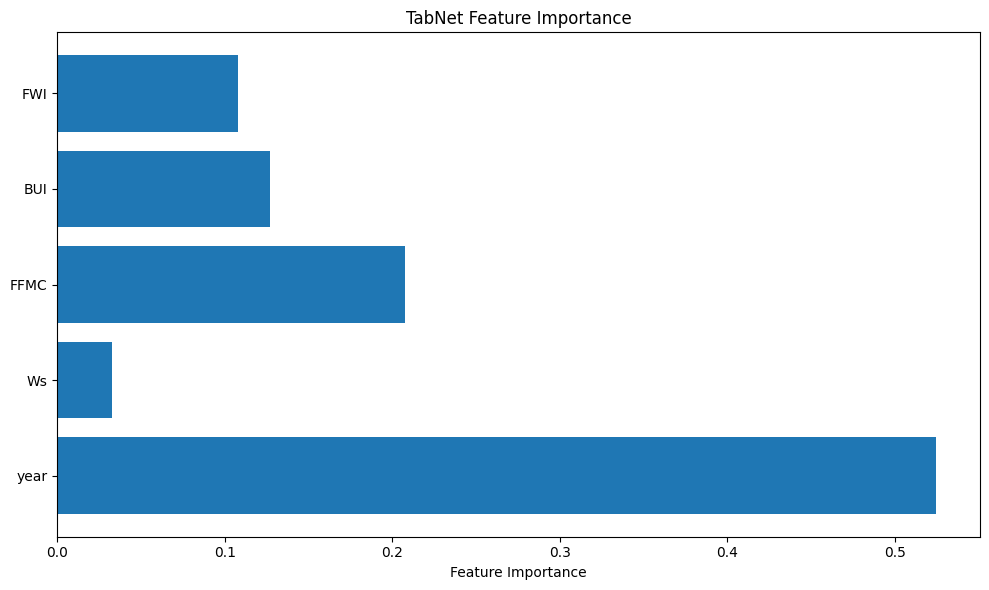

F1 Score: 0.8763


In [ ]:
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train1)

X_train_np = X_train_scaled.astype("float32")
X_test_np = X_test_scaled.astype("float32")
y_train_np = y_train.values
y_test_np = y_test.values

# Initialize and Train TabNet
clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=1,
    seed=42
)

clf.fit(
    X_train=X_train_np, y_train=y_train_np,
    eval_set=[(X_train_np, y_train_np), (X_test_np, y_test_np)],
    eval_name=['train', 'valid'],
    eval_metric=['accuracy'],
    max_epochs=70,
    patience=25,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    weights=sample_weights  # fixes the imbalance

)

# Evaluate Model
y_pred = clf.predict(X_test_np)
print("Classification Report:\n", classification_report(y_test_np, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_np, y_pred))

# Plot Feature Importances
feature_names = X.columns
importances = clf.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("TabNet Feature Importance")
plt.tight_layout()
plt.show()
print(f"F1 Score: {f1_score(y_test_np, y_pred, average='weighted'):.4f}")


LSTM

In [ ]:
# Reshape (3D: samples, timesteps, features)
X_train_lstm = X_train1.values.reshape((X_train1.shape[0], X_train1.shape[1], 1))
X_test_lstm = X_test1.values.reshape((X_test1.shape[0], X_test1.shape[1], 1))

model_lstm = Sequential([
    LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]),
         kernel_regularizer=regularizers.l2(0.001), return_sequences=False),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model_lstm.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history_lstm = model_lstm.fit(
    X_train_lstm, y_train_enc1,
    validation_data=(X_test_lstm, y_test_enc1),
    epochs=70, batch_size=16, verbose=1,
    callbacks=[early_stop]
)

loss, acc = model_lstm.evaluate(X_test_lstm, y_test_enc1, verbose=0)
print("LSTM Test Accuracy:", acc)

y_pred_probs = model_lstm.predict(X_test_lstm)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()
y_true_classes = y_test_enc1

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(f"\nConfusion Matrix:\n {cm}")

# Classification Report
print(f"\nClassification Report:{classification_report(y_true_classes, y_pred_classes)}")

# F1 Score
f1_fire = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f"\nF1 Score: {f1_fire:.4f}")


Epoch 1/70


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7217 - loss: 0.5810 - val_accuracy: 0.7558 - val_loss: 0.5051
Epoch 2/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7821 - loss: 0.5040 - val_accuracy: 0.7733 - val_loss: 0.4665
Epoch 3/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8211 - loss: 0.4546 - val_accuracy: 0.8605 - val_loss: 0.4566
Epoch 4/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8199 - loss: 0.4508 - val_accuracy: 0.8895 - val_loss: 0.4059
Epoch 5/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8612 - loss: 0.4170 - val_accuracy: 0.8663 - val_loss: 0.3782
Epoch 6/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8816 - loss: 0.3951 - val_accuracy: 0.8779 - val_loss: 0.3606
Epoch 7/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8540 - loss: 0.4161 - val_accuracy: 0.8663 - val_loss: 0.3658
Epoch 8/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8756 - loss: 0.3540 - val_accuracy: 0.8663 - val_loss: 0.3579


CNN2D

In [ ]:
#CNN2D: (samples, rows, cols, channels)
X_train_cnn2d = X_train_scaled.reshape(-1, X_train_scaled.shape[1], 1, 1)
X_test_cnn2d = X_test_scaled.reshape(-1, X_test_scaled.shape[1], 1, 1)

#buikd the model
model_cnn2d = Sequential([
    Conv2D(filters=32, kernel_size=(3,1), activation='relu',
           kernel_regularizer=regularizers.l2(0.001),
           input_shape=(X_train_cnn2d.shape[1], X_train_cnn2d.shape[2], 1)),
    MaxPooling2D(pool_size=(2,1)),
    Dropout(0.5),

    Conv2D(filters=64, kernel_size=(3,1), activation='relu',
           kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D(pool_size=(2,1)),
    Dropout(0.5),

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile
model_cnn2d.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training
history_cnn2d = model_cnn2d.fit(
    X_train_cnn2d, y_train_enc1,
    validation_data=(X_test_cnn2d, y_test_enc1),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# Evaluation
loss, acc = model_cnn2d.evaluate(X_test_cnn2d, y_test_enc1, verbose=0)
print(" CNN2D Test Accuracy:", acc)

y_pred_probs = model_cnn2d.predict(X_test_cnn2d)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()
y_true_classes = y_test_enc1

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(f"\nConfusion Matrix:\n{cm}")

# Classification Report
print(f"\nClassification Report:\n{classification_report(y_true_classes, y_pred_classes)}")

# F1 Score
f1_fire = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f"\n F1 Score: {f1_fire:.4f}")

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.6624 - loss: 0.7446 - val_accuracy: 0.7558 - val_loss: 0.6239
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7531 - loss: 0.6457 - val_accuracy: 0.7558 - val_loss: 0.5560
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7792 - loss: 0.6018 - val_accuracy: 0.8372 - val_loss: 0.4997
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8355 - loss: 0.5294 - val_accuracy: 0.8779 - val_loss: 0.4720
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8082 - loss: 0.5376 - val_accuracy: 0.8779 - val_loss: 0.4430
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8644 - loss: 0.4796 - val_accuracy: 0.8895 - val_loss: 0.4348
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8416 - loss: 0.4691 - val_accuracy: 0.8895 - val_loss: 0.4286
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8617 - loss: 0.4461 - val_accuracy: 0.8895 - val_loss: 0.

##RFECV

In [ ]:
# load data
df_RFECV = pd.read_csv("/content/merged_fire_data_cleaned.csv")

X = df_RFECV.drop("Classes", axis=1)
y = df_RFECV["Classes"]

# splite data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# RFECV with XGboost

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rfecv = RFECV(
    estimator=XGBClassifier(random_state=42, n_estimators=300, learning_rate=0.1),
    step=1,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)

rfecv.fit(X_train_scaled, y_train)

#Extract selected features

selected_features = X.columns[rfecv.support_]

print("RFECV RESULTS")
print("Selected Features:", selected_features.tolist())
print("Number of Features:", rfecv.n_features_)


RFECV RESULTS
Selected Features: ['day', 'month', 'year', 'Temperature', 'Ws', 'Rain', 'FFMC', 'DC', 'ISI', 'BUI']
Number of Features: 10


In [ ]:
X_train2 = X_train[selected_features]
X_test2 = X_test[selected_features]

scaler2 = StandardScaler()
X_train2_scaled = scaler2.fit_transform(X_train2)
X_test2_scaled = scaler2.transform(X_test2)

Apply the Feature Selection for the best 6 models

XGBoost with Oversampler

In [ ]:
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train2, y_train)
# Encode labels
le = LabelEncoder()
y_train_enc2 = le.fit_transform(y_train)
y_test_enc2 = le.transform(y_test)

# XGBoost
xgb = XGBClassifier(random_state=42, eval_metric="mlogloss")

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}
grid_xgb = GridSearchCV(xgb, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_xgb.fit(X_train_res, y_train_res)

print("Best params:", grid_xgb.best_params_)
print("Best CV Accuracy:", grid_xgb.best_score_)

best_xgb1 = grid_xgb.best_estimator_
cv_scores = cross_val_score(best_xgb1, X_train_res, y_train_res, cv=5, scoring="accuracy")
print("CV Scores:", cv_scores)
print("Mean CV:", cv_scores.mean())

y_pred_xgb = best_xgb1.predict(X_test2)
print("Test Accuracy:", accuracy_score(y_test_enc2, y_pred_xgb))

f1_fire = f1_score(y_test_enc2, y_pred_xgb, average='weighted')
print(f"Overall F1 Score: {f1_fire:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb, target_names=["not fire", "fire"]))


Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Best CV Accuracy: 0.9796444819661367
CV Scores: [0.98067633 0.98550725 0.97572816 0.97572816 0.98058252]
Mean CV: 0.9796444819661367
Test Accuracy: 0.9418604651162791
Overall F1 Score: 0.9427

Classification Report:
               precision    recall  f1-score   support

    not fire       0.98      0.95      0.96       130
        fire       0.85      0.93      0.89        42

    accuracy                           0.94       172
   macro avg       0.91      0.94      0.92       172
weighted avg       0.94      0.94      0.94       172



catboost

In [ ]:
model = CatBoostClassifier(
    verbose=0,
    random_state=42
)

param_grid = {
    'iterations': [200, 400],
    'depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train2, y_train)

print(" Best Parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_cat = best_model.predict(X_test2)

print("\nAccuracy:", round(accuracy_score(y_test, y_pred_cat), 4))
f1_fire = f1_score(y_test, y_pred_cat, average='weighted')
print(f" Overall F1 Score: {f1_fire:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_cat))


Fitting 5 folds for each of 54 candidates, totalling 270 fits
 Best Parameters: {'depth': 6, 'iterations': 200, 'l2_leaf_reg': 5, 'learning_rate': 0.2}

Accuracy: 0.9477
 Overall F1 Score: 0.9479

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97       130
           1       0.88      0.90      0.89        42

    accuracy                           0.95       172
   macro avg       0.93      0.93      0.93       172
weighted avg       0.95      0.95      0.95       172



Ensample training

In [ ]:
catboost_model = CatBoostClassifier(
    iterations=400,
    depth=6,
    learning_rate=0.1,
    l2_leaf_reg=3,
    verbose=0,
    random_state=42
)
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(**grid_svm.best_params_, probability=True, random_state=42))
])

# XGBoost doesn’t need scaling
xgb_model = XGBClassifier(**grid_xgb.best_params_, random_state=42, eval_metric='mlogloss')

# Create the VotingClassifier
voting_clf = VotingClassifier(
    estimators=[
        ('catBoost', catboost_model),
        ('svm', svm_pipeline),
        ('xgb', xgb_model)
    ],
    voting='soft'  # Use soft voting to benefit from predicted probabilities
)

# Fit the ensemble
voting_clf.fit(X_train2, y_train_enc2)

# Evaluate on test set
y_pred_ensemble = voting_clf.predict(X_test2)

from sklearn.metrics import accuracy_score, classification_report
print("Ensemble Test Accuracy:", accuracy_score(y_test_enc2, y_pred_ensemble))
f1_fire = f1_score(y_test_enc2, y_pred_ensemble, average='weighted')
print(f"Overall F1 Score: {f1_fire:.4f}")

print("\nEnsemble Classification Report:\n", classification_report(y_test, y_pred_ensemble, target_names=["not fire", "fire"]))


Ensemble Test Accuracy: 0.9534883720930233
Overall F1 Score: 0.9535

Ensemble Classification Report:
               precision    recall  f1-score   support

    not fire       0.97      0.97      0.97       130
        fire       0.90      0.90      0.90        42

    accuracy                           0.95       172
   macro avg       0.94      0.94      0.94       172
weighted avg       0.95      0.95      0.95       172



TabNet model

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.96959 | train_accuracy: 0.51462 | valid_accuracy: 0.50581 |  0:00:00s
epoch 1  | loss: 0.66358 | train_accuracy: 0.59211 | valid_accuracy: 0.62209 |  0:00:00s
epoch 2  | loss: 0.60881 | train_accuracy: 0.66959 | valid_accuracy: 0.6686  |  0:00:00s
epoch 3  | loss: 0.5881  | train_accuracy: 0.72953 | valid_accuracy: 0.68605 |  0:00:00s
epoch 4  | loss: 0.52717 | train_accuracy: 0.72222 | valid_accuracy: 0.7093  |  0:00:00s
epoch 5  | loss: 0.49413 | train_accuracy: 0.72368 | valid_accuracy: 0.68605 |  0:00:00s
epoch 6  | loss: 0.50074 | train_accuracy: 0.74708 | valid_accuracy: 0.72674 |  0:00:00s
epoch 7  | loss: 0.47484 | train_accuracy: 0.77047 | valid_accuracy: 0.75    |  0:00:01s
epoch 8  | loss: 0.43292 | train_accuracy: 0.78801 | valid_accuracy: 0.76163 |  0:00:01s
epoch 9  | loss: 0.40556 | train_accuracy: 0.84064 | valid_accuracy: 0.82558 |  0:00:01s
epoch 10 | loss: 0.41802 | train_accuracy: 0.83626 | valid_accuracy: 0.82558 |  0:00:01s
epoch 11 | loss: 0.38

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


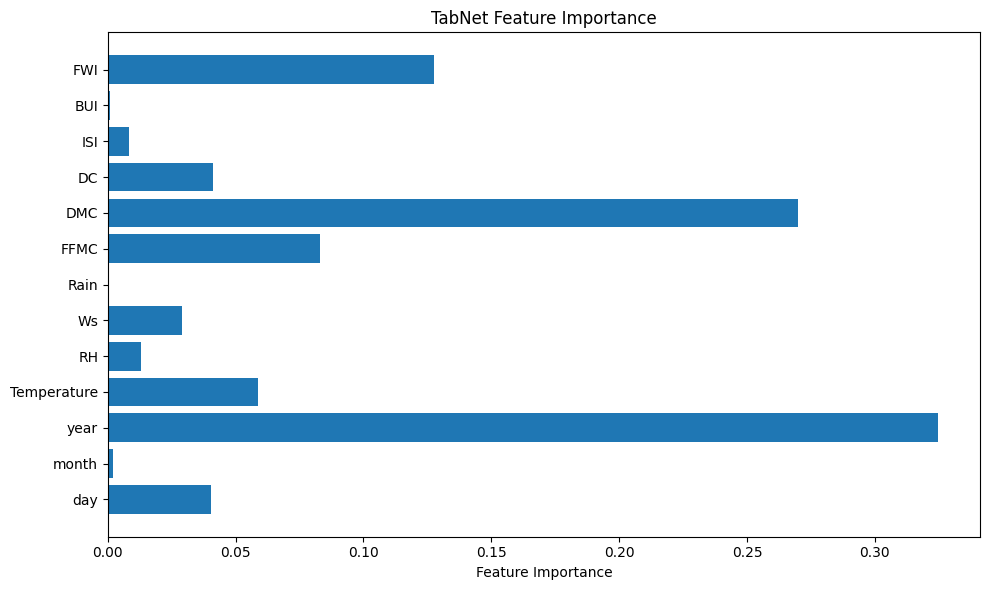

F1 Score: 0.9358


In [ ]:
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

X_train_np = X_train_scaled.astype("float32")
X_test_np = X_test_scaled.astype("float32")
y_train_np = y_train.values
y_test_np = y_test.values

# Initialize and Train TabNet
clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=1,
    seed=42
)

clf.fit(
    X_train=X_train_np, y_train=y_train_np,
    eval_set=[(X_train_np, y_train_np), (X_test_np, y_test_np)],
    eval_name=['train', 'valid'],
    eval_metric=['accuracy'],
    max_epochs=70,
    patience=25,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    weights=sample_weights  # fixes the imbalance

)

# Evaluate Model
y_pred = clf.predict(X_test_np)
print("Classification Report:\n", classification_report(y_test_np, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_np, y_pred))

# Plot Feature Importances
feature_names = X.columns
importances = clf.feature_importances_
importances = importances[:len(feature_names)]  # keep only real feature importances

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("TabNet Feature Importance")
plt.tight_layout()
plt.show()
print(f"F1 Score: {f1_score(y_test_np, y_pred, average='weighted'):.4f}")


LSTM

In [ ]:
# Reshape (3D: samples, timesteps, features)
X_train_lstm = X_train2.values.reshape((X_train2.shape[0], X_train2.shape[1], 1))
X_test_lstm = X_test2.values.reshape((X_test2.shape[0], X_test2.shape[1], 1))

model_lstm = Sequential([
    LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]),
         kernel_regularizer=regularizers.l2(0.001), return_sequences=False),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model_lstm.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history_lstm = model_lstm.fit(
    X_train_lstm, y_train_enc2,
    validation_data=(X_test_lstm, y_test_enc2),
    epochs=50, batch_size=16, verbose=1,
    callbacks=[early_stop]
)

loss, acc = model_lstm.evaluate(X_test_lstm, y_test_enc2, verbose=0)
print("LSTM Test Accuracy:", acc)

y_pred_probs = model_lstm.predict(X_test_lstm)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()
y_true_classes = y_test_enc2

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(f"\nConfusion Matrix:\n {cm}")

# Classification Report
print(f"\nClassification Report:{classification_report(y_true_classes, y_pred_classes)}")

# F1 Score
f1_fire = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f"\nF1 Score: {f1_fire:.4f}")


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7142 - loss: 0.6003 - val_accuracy: 0.7558 - val_loss: 0.4856
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7671 - loss: 0.5316 - val_accuracy: 0.8081 - val_loss: 0.4318
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8029 - loss: 0.4394 - val_accuracy: 0.8779 - val_loss: 0.3962
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8599 - loss: 0.4145 - val_accuracy: 0.8663 - val_loss: 0.3826
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8598 - loss: 0.3930 - val_accuracy: 0.8721 - val_loss: 0.3815
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8318 - loss: 0.4486 - val_accuracy: 0.8721 - val_loss: 0.3706
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8594 - loss: 0.3719 - val_accuracy: 0.8721 - val_loss: 0.3784
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8665 - loss: 0.3655 - val_accuracy: 0.8663 - val_loss: 0.3740

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Confusion Matrix:
 [[129   1]
 [ 16  26]]

Classification Report:              precision    recall  f1-score   support

           0       0.89      0.99      0.94       130
           1       0.96      0.62      0.75        42

    accuracy                           0.90       172
   macro avg       0.93      0.81      0.85       172
weighted avg       0.91      0.90      0.89       172


F1 Score: 0.8931


CNN2D

In [ ]:
#CNN2D: (samples, rows, cols, channels)
X_train_cnn2d = X_train_scaled.reshape(-1, X_train_scaled.shape[1], 1, 1)
X_test_cnn2d = X_test_scaled.reshape(-1, X_test_scaled.shape[1], 1, 1)

#buikd the model
model_cnn2d = Sequential([
    Conv2D(filters=32, kernel_size=(3,1), activation='relu',
           kernel_regularizer=regularizers.l2(0.001),
           input_shape=(X_train_cnn2d.shape[1], X_train_cnn2d.shape[2], 1)),
    MaxPooling2D(pool_size=(2,1)),
    Dropout(0.5),

    Conv2D(filters=64, kernel_size=(3,1), activation='relu',
           kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D(pool_size=(2,1)),
    Dropout(0.5),

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile
model_cnn2d.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training
history_cnn2d = model_cnn2d.fit(
    X_train_cnn2d, y_train_enc2,
    validation_data=(X_test_cnn2d, y_test_enc2),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# Evaluation
loss, acc = model_cnn2d.evaluate(X_test_cnn2d, y_test_enc2, verbose=0)
print(" CNN2D Test Accuracy:", acc)

y_pred_probs = model_cnn2d.predict(X_test_cnn2d)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()
y_true_classes = y_test_enc2

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(f"\nConfusion Matrix:\n{cm}")

# Classification Report
print(f"\nClassification Report:\n{classification_report(y_true_classes, y_pred_classes)}")

# F1 Score
f1_fire = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f"\n F1 Score: {f1_fire:.4f}")

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6617 - loss: 0.7586 - val_accuracy: 0.7558 - val_loss: 0.6247
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7599 - loss: 0.6463 - val_accuracy: 0.8023 - val_loss: 0.5384
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7652 - loss: 0.5788 - val_accuracy: 0.8663 - val_loss: 0.4886
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8271 - loss: 0.5054 - val_accuracy: 0.9012 - val_loss: 0.4527
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8595 - loss: 0.4909 - val_accuracy: 0.9012 - val_loss: 0.4420
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8616 - loss: 0.4709 - val_accuracy: 0.8953 - val_loss: 0.4351
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8603 - loss: 0.4526 - val_accuracy: 0.8953 - val_loss: 0.4205
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8348 - loss: 0.4732 - val_accuracy: 0.8953 - val_loss: 0.4158
Ep